# Can a lock-in effect explain the observed diversity of particulate matter and dissolved organic matter in the respective experiments?

### Model description

The following model simulates the choice of DOM and PM combinations to study in hypothetical experiments for a period of 26 years. It corresponds to the period analyzed by the paper regarding the experimental network analysis, which summarizes the material employed mainly between 1990 and 2015 in experiments that study the fate of particulate matter in aquatic media.
The model is calibrated with the following data:

* Number of researchers entering the field in each year n(t)
* The life expectancy of a researcher in the field, or the probability of leaving the field as a function of years of activity.
* The average number of collaboration group sizes (average number of coauthors per paper)
* The average number of experiments done in a single publications


Model dynamics: In each time step n new researchers enter the field, where n is an empirical number:

* The researchers are split into collaboration groups of the empirical size
* They acquire the average opinion of their collaborators
* They compare their average opinion to the expected innovation threshold in the community (how tolerant is the community to innovation in scale from 0 to 1?)
* if their opinion is above the threshold they just imitate (conservative approach) else they choose materials at random (innovative approach)
* The collaboration group disintegrates only if at least one of its members leaves the field
* Remaining members of disintegrated collaboration groups are regrouped into new collaboration groups.


Alternative thought:

* According to discussion with people who carry out experiments it seems that a lock in effect is mainly due to internal concerns where people are more likely to focus on materials they are used to use, due to for example technical optimization of machines, etc.



Parameters to modify in each model simulation:


* condUpdate - conditional update of the opinions - a logical parameters, if "True" then agents update their opinion at the end of time t to match the average opinion of their collaboration group at that time, if their choice of materials in the current time step was successful, i.e. other groups also studied at least one identical combination of DOM-PM. If "False" then the agents adopt the average group opinion as their own. Use: model.condUpdate = True or model.condUpdate = False
* allowMixing - whether or not the new incoming agents are allowed to create collaboration groups with agents that are already in the system - A logical argument, if "True" there is no segregation into "new" and "old" agents, at the end of each time step all agents, not assigned yet to a collaboration group (including those who got their group disintegrated, are allowed to create collaboration groups. If "False" newcomers create collaboration groups among themselves (i.e. researchers entering the field already in formed collaboration groups) and existing agents, who got their group disintegrate, will form collaborative groups only among themselves (not with the newcomers). Use: model.allowMixing = True or model.allowMixing = False


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats
import igraph
import random
%matplotlib inline

How to verify that you can actually use igraph?
in the temrinal write: 
### $> sudo ipython notebook 

In [3]:
class materialChoice:
    """This is a class object used to model the choice of materials in the experiemntal field that investigated
    the effect of DOM on PM"""
    #def __init__(self, nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, nExpr, nCharac,\
     #            studiedComb = studiedComb, studiedTimes = studiedTimes, studiedCombWeights = weights):
    def __init__(self, nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, nExpr, nCharac,\
             studiedCombWeights):
        """The initialization function that sets the main attributes of the model object (calibration attribute)
        'nAgents' = number of agents at the begining of the simulation
        'pmTypes' = number of the main experimental components types (e.g. engineered nanoparticles types)
        'domTypes' = number of the secondery experimental components types (e.g. dissolved organic matter or test organism)
        'collSize' = number of coauthors on a paper / number of researches in a collaboration group
        'lifeExpect' = the weibull distribution parameter indicating what are the chances of leaving the field given the
        years of activity
        'newAgents' = the number of new researchers entering the field in each year
        'threshold' = the community threshold for innovation
        'studiedComb' = the number of combinations studied for each amount of repetition as given below, for example
        if the studiedComb[0] = 32 and studiedTimes[0] = 1, it means that by the start of the simulation there were
        32 combinations studied each one only once
        'n_expr' = the number of experiments done per paper
        'n_charac' = the number of charachterization methods available for each main component (potentially)
        studiedCombWeights = initial weights distribution at the begining of the simuation
        """
        #agents related intialization values:
        if nAgents != collSize:
            nAgents = collSize#in case the inital number of agents cannot construct a group, the code sets that number
        #to the size of a collaboration group!
            #print("I adjusted number of initial agents to the size of the collaboration group")
        self.nAgents = nAgents
        self.collSize = collSize
        self.lifeExpect = lifeExpect#a probability array
        self.newAgents = newAgents#the list of the empirical number of agents added in each year
        self.allowMixing = False#should newcomers pair up with existing researchers? as a default is set to false,,
        self.condUpdate = True#conditional update as a default agents update their opinion is their materials choice was relevant,
        self.InnovNoise = 0.05#this value defines likelihood of conservative collaboration group to still explore new materials
       
        #materials related initialization values:
        self.pmTypes = pmTypes
        self.domTypes = domTypes       
        self.threshold = threshold
        #self.studiedComb = studiedComb#empirical values of how many and how often combinations were studied before the simulation started
        #self.studiedTimes = studiedTimes
        self.studiedCombWeights = studiedCombWeights
        self.nCharac = nCharac#number of characterization protocols
        self.memory = False #should materials be picked up for innovation using memory?
        self.nExperiments = nExpr#the number of experiments to be chosen by each collaboration group
        #which accounts for the possibility of other factors that determine the choice of materials that are not explicitly
        #accounted for in the model.
        #however this can be changed after model initialization and the agents 
        #after the model instance is initiated it can be set otherwise (before runModel() is called)
        self.autoregress = False#if true then the choice of materials is influenced by the most recent year choice
        #of materials.
        #
        self.simulationstepCounter = []#counter of the simulation step to accumulate with the mean group tendency
        #
        #Initialize properties based on the object function
        self.countExpr = 0
        #self.setCollaboComb()#a list of touples with the combinations of indeces of agents in a collaboration group,
        #later used to create the collaboration network
        self.setAgentAttrib(init = True)#assigns the tendency to repeat materials of each agent
        self.allMaterialsComb()#creates a large array of all materials combinations
        self.initExpCharach()#a place holder to contain the experimental settings reported for the main
        #constituent 
        #self.setCollGroup(np.arange(self.nAgents),init=True)
        self.setCollGroupInit(np.arange(self.nAgents))
        self.diversityIndex = []#will accumulate the diveristy index of the materials investigated
        self.meanTendency = []#the mean tendency of agents
    def setAgentAttrib(self, agentsToAdd = 0, init = False):
        """This function creats a dictionary structure for the model object, where each key is an agent
        agents are identified by their position on the grid i.e: 'cellx-coly and sets the initial attribue of each agent
        The function either initialize the dictionary of agents attribute or adds new agents to the already existing
        dictionary"""
        if init:
            self.agents_attribute = {}#the agents dictionary
            toAdd = np.arange(self.nAgents)#the indices of the agents to be added if the function was alreay initialized 
        else:
            toAdd = np.arange(self.nAgents,self.nAgents + agentsToAdd)#if this is not the first inialization, then arrange
            #the new added agents in an array
        self.nAgents = self.nAgents + agentsToAdd#update the number of agents
        for agent in toAdd:#cell[0] - row of the agent and cell[1] - col of the agent
                #print(agent)
                self.agents_attribute[str(agent)] = {}#for each agenta n intial dictionary is set
                self.agents_attribute[str(agent)]["baseline tendency"] = np.random.random(1)#a random number between 0 and 1
                #from a uniform distribution
                self.agents_attribute[str(agent)]["current tendency"] = self.agents_attribute[str(agent)]["baseline tendency"]
                #the average tendency of the current collaboration group
                self.agents_attribute[str(agent)]["collaboraton tendency"] = self.agents_attribute[str(agent)]["baseline tendency"]
                #self.agents_attribute[str(agent)]["PM studied"] = []
                #self.agents_attribute[str(agent)]["DOM studied"] = []
                self.agents_attribute[str(agent)]["comb studied"] = []#the combinations studied in each time step,
                #a nested list
                self.agents_attribute[str(agent)]["collaborators"] = []#the collaborators with whome the agent
                #was assigned to the exact same collaboration group, also a nested list
                self.agents_attribute[str(agent)]["age"] = 0#the age of the agent, which will determine his likelihood to die as
                #time progresses
                self.agents_attribute[str(agent)]["state"] = "alive"#is the agent dead or alive? alive agents
                #are active researchers, dead agents are not active researchers
        return(toAdd)
    def allMaterialsComb(self):
        """This function creates an array of all possible DOM and PM types (where number of types are given from 
        empirical data) and creates arrays of weights for PM and DOM"""
        self.allComb = np.zeros((1,3))#an array of three columns, the first is the PM type, the second
        #is the DOM type, the third is the weight:
        self.allComb_id = []#a list of all cmobinations in a string form: "pm-dom" to enable easier extraction later on
        for pm in np.arange(self.pmTypes):
            for dom in np.arange(self.domTypes):
                self.allComb = np.vstack((self.allComb,np.array([pm,dom,0])))
                self.allComb_id.append(str(np.double(pm)) + "-" + str(np.double(dom)))
        #remove the first row, which contains the [0,0,0] that were used to initialize the model:
        self.allComb = np.delete(self.allComb,1,axis = 0)#remove the first row (axis zero)
        self.allComb_id = np.array(self.allComb_id)#convert into np array for easier indexing
        #self.comProb = np.zeros((np.shape(self.allComb)[0],))# the forth is the probability of choosing the given comb
        #
        #add the initial conditions presented before the simulation started (in 1990): we arbitrarily update the first
        #38 combinations, as the actual combinations in the simulations have no meaning by themselves
        #startPoint = 0
        #for comb in np.arange(len(self.studiedComb)):
         #   self.allComb[startPoint:(startPoint + self.studiedComb[comb]),2] = self.studiedTimes[comb]#adding weight of 1 to comb studied once before 1990
          #  startPoint = startPoint + self.studiedComb[comb]#update the starting point such that we take consequtive combinations
        self.allComb[:, 2] = self.studiedCombWeights
        #the following creates an array for each DOM and PM constituents and it will store the number of times each material
        #was used sequencially in the model simulation
        self.domProb = np.ones(self.domTypes)
        self.pmProb = np.ones(self.pmTypes)
        #Feel the array with the weights (number of times a material was used) in the intial conditions:
        for dom in np.arange(self.domTypes):
            self.domProb[dom] = self.domProb[dom] + np.sum(self.allComb[self.allComb[:, 1] == dom, 2])
        for pm in np.arange(self.pmTypes):
            self.pmProb[pm] = self.pmProb[pm] + np.sum(self.allComb[self.allComb[:, 0] == pm, 2])
    def initExpCharach(self):
        """This function initialize a dictionray for the characterization protocols of the main component
        of the experiment"""
        self.exprCharc = {}
        for i in np.arange(self.pmTypes):
            self.exprCharc[i] = np.ones(self.nCharac)
        #update the protocols for the initial experiments done before the simulation started:
        #for w in self.allComb[np.where(self.allComb[:, 2] > 0)[0], 0]:
         #   mainComp = np.int(w)
          #  self.exprCharc[mainComp] = self.exprCharc[w] + self.allComb[mainComp, 2]
    def setCollaboComb(self):
        """This function returns the combinations of indeces of agents in a collaboration group of size self.collSize
        in order to create the collaboration network"""
        indexComb = []
        for i in np.arange(self.collSize):
            for j in np.arange(i+1,stop = self.collSize):
                indexComb.append((i,j))
        self.indexComb = indexComb
    def setCollGroupInit(self, arrayAgents, tStep = 0):
        """
        This function sets the collaboration group for the first group of researchers
        """
        if tStep == 0 or len(self.collGroups) == 0:
            self.collGroups = np.repeat(-1, self.collSize)
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) >= self.collSize:#if the agents cannot be split into even collaboration groups
            fitToSplit = arrayAgents[:len(arrayAgents) - len(arrayAgents)%self.collSize]#the agents that can be split evenly into collaboration groups of size: self.collSize
            remainder = arrayAgents[-1*(len(arrayAgents)%self.collSize):] #create a collaboration group with dummy agents
            remainder = np.append(remainder, np.repeat(-1, self.collSize-len(remainder)))#fill in the remainder with dummy agents
            collGroups = np.split(np.random.choice(fitToSplit, len(fitToSplit), replace = False),\
                                   len(fitToSplit)/self.collSize)
            if len(self.collGroups) == 0:
                self.collGroups = collGroups
            else:
                self.collGroups = np.vstack((self.collGroups, collGroups))
            self.collGroups = np.vstack((self.collGroups, remainder))
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) < self.collSize:
            #if there is only one/two agent in the group to be reassigned just reassiged them to a group again
            #and return to exit this function
            lonelyGroup = np.append(arrayAgents,np.repeat(-1,self.collSize-len(arrayAgents)))
            if len(self.collGroups) == 0:
                self.collGroups = lonelyGroup
            else:
                self.collGroups = np.vstack((self.collGroups, lonelyGroup))
        if len(arrayAgents)%self.collSize == 0:#if the number of agents is devisible by the size of the collaboration group
            if len(arrayAgents) ==0:
                collGroups = np.repeat(-1, self.collSize)
            else:
                fitToSplit = arrayAgents
                collGroups = np.split(np.random.choice(fitToSplit,len(fitToSplit),replace = False),\
                                   len(fitToSplit)/self.collSize)
            if len(self.collGroups) == 0:
                self.collGroups = collGroups
            else:
                self.collGroups = np.vstack((self.collGroups, collGroups))
        #if tStep == 0:
         #   self.collGroups = self.collGroups[:][1:]
    def setCollGroup(self, agentsExisting, agentsNew):
        """
        This function sets the collaboration groups with the agents for all time steps other than time step 0
        It takes as arguments the list of existing agents that need reassignment and a list of newcommers.
        If the self.mix argument is set to true it mixes the existing and new agents.
        Else, it creates collaboration groups with exisitng agents and collaboration groups with newcomers.
        In case of such seperation, the exisitng agents are mixed preferably with collborators with whome they
        collaborated in the past.
        """
        #take only the agents that are "alive" (from the existing agents, the new agents are always set to "alive" as a defualt)
        aliveArray = np.array([])#a place holder for the accumulation of living agents 
        for agent in agentsExisting:
            if agent != -1:#if it's a real agent
                if self.agents_attribute[str(agent)]["state"] == "alive":
                    aliveArray = np.append(aliveArray,agent)
        aliveArray = aliveArray.astype("int")#change the agents that are being assigend to groups now only to living ones
        #in case all agents died there is no collaboration group
        if len(aliveArray) > len(np.unique(aliveArray)):
            print(aliveArray)
        aliveArray = np.unique(aliveArray)
        if self.allowMixing:
            #If mixing is allowed between newcomers and existing agents
            if len(agentsNew) > 0:
                allAgents = np.append(aliveArray, agentsNew)
                self.setCollGroupInit(allAgents, tStep = 1)#
            else:
                self.setCollGroupInit(aliveArray, tStep = 1)#in case no new agents were added in this timestep
            return()
        if not self.allowMixing:
            #If mixing is not allowed between newcomers and existing agents
            existingAgents_nocoll = np.array([]) #those are agents that are not new, but have no prefered collaborators, will
            #be grouped with new agents:
            if len(agentsNew) ==0:
                agentsNew = np.array([])#if no new agents are added at this time step
            for a in aliveArray:
                if len(self.agents_attribute[str(a)]["collaborators"]) == 0:
                    agentsNew = np.append(agentsNew, a)    
                    aliveArray = np.delete(aliveArray, np.where(aliveArray == a)[0][0])
            if len(agentsNew) >0:
                self.setCollGroupInit(agentsNew, tStep = 1)#creates groups for new comers seperately
            #create groups of existing agents alone, with preference to collaborate with people they already
            #collaborated in the past with:
            if len(aliveArray) == 0:#if all exsiting agets died, return()
                return()
            if len(aliveArray) <= self.collSize:#if the number of agents for reassignment is smaller than
                    #or equal to the collaboration group size
                    #append them all to one remainer collaboration gruop with palce holders, 
                    #they won't participate in the next round
                    remainder = np.append(aliveArray, np.repeat(-1, self.collSize-len(aliveArray)))
                    self.collGroups = np.vstack((self.collGroups,remainder))
                    return()
            while len(aliveArray) > 0:#while we still have agents to reassign and they are more than one group in size
                    currentAgent = aliveArray[0]#take the first agent in the arrayAgent
                    #aliveArray = np.delete(aliveArray, np.where(aliveArray == currentAgent)[0][0])#delete the first agent
                    aliveArray = aliveArray[1:]
                    collGroup = np.array([currentAgent])
                    preferedCollFirstDegree = self.agents_attribute[str(currentAgent)]["collaborators"][0]#obtain its perfered collaborators
                    for i in preferedCollFirstDegree:
                        if not i in aliveArray or i ==currentAgent:
                            continue#if the prefered colaborator is not in the array of agents to be reassigned then skipped her
                        if len(collGroup) < self.collSize and not i in collGroup:#if we still less then the collaboration grup size
                            collGroup = np.append(collGroup, i)
                            aliveArray = np.delete(aliveArray, np.where(aliveArray == i)[0][0])#remove this agent from the list
                        if len(collGroup) < self.collSize and not i in collGroup:#if we still need new agents to create the collaboration
                            preferedCollSecondDegree = self.agents_attribute[str(i)]["collaborators"][0]#the prefered collaborators of
                            #the agents that is himself the prefered collaborator of the analyzed agent
                            for j in preferedCollSecondDegree:
                                if j in aliveArray and len(collGroup) < self.collSize and not j in collGroup:
                                    collGroup = np.append(collGroup, j)
                                    aliveArray = np.delete(aliveArray, np.where(aliveArray == j)[0][0])
                        if len(collGroup) < self.collSize:#if we still didn't fill all the required number of agents
                            if len(aliveArray) >= self.collSize-len(collGroup):
                                collGroup = np.append(collGroup, aliveArray[0:self.collSize-len(collGroup)])
                                aliveArray = aliveArray[(self.collSize-len(collGroup)):]
                            else:#if there are not enough agents in the agets array to make this a full collaboration group
                                #add them and fill the rest with minus ones
                                collGroup = np.append(collGroup, aliveArray)
                                collGroup = np.append(collGroup, np.repeat(-1,self.collSize-len(collGroup)))
                                aliveArray = np.array([])
                        #finally append the colaboration group to the list of all collaborations:
                        self.collGroups = np.vstack((self.collGroups,collGroup))
    
   
    def calcGruopTend(self,group):
        """for the given collaboration group ('group' argument) this function calculates the tendency to repeat
        materials in experiments"""
        tendency = 0
        lenGroup = 0#number of real agents, such that if there is -1 (a palce holder) it won't be counted
        for i in np.arange(len(group)):
            if group[i] != -1:
                tendency = tendency + self.agents_attribute[str(group[i])]["current tendency"]
                lenGroup = lenGroup + 1#count the number of real agents
        return(np.double(tendency/lenGroup))#return the average tendency of the current group
    def updateCollaborationListMaterials(self,group,comb):
        """This function updates the list of collaborators and materials used for the given time step for every agent,
        where group is the currently analyzed collaboration group and comb is a list of rows indicating the
        DOM-PM combinations analyzed in this time step by the given group"""
        combList = []
        for j in comb:
            combList.append(str(self.allComb[j,0]) + "-" + str(self.allComb[j,1]))
        for i in np.arange(len(group)):
            if group[i] != -1:
                self.agents_attribute[str(group[i])]["comb studied"].append(combList)#append the list of material
                #combinations studied for the given collaboration group to each one of it's members
                collaborators = list(np.delete(group,i))#all other collaborators in the given group except for the given agent
                self.agents_attribute[str(group[i])]["collaborators"].append(collaborators)
    def updateCmobStudied(self, group, comb):
        """
        Update the combiantions studied for each memeber of a collaboration group
        """
        combList = []
        for j in comb:
            combList.append(str(self.allComb[j,0]) + "-" + str(self.allComb[j,1]))
        for i in np.arange(len(group)):
            if group[i] != -1:
                self.agents_attribute[str(group[i])]["comb studied"].append(combList)#append the list of material
                #combinations studied for the given collaboration group to each one of it's members
    def updateCollaborationList(self, group):
        """
        Update the collaboration conncetions
        """
        for i in np.arange(len(group)):
            if group[i] != -1:
                collaborators = list(np.delete(group,i))#all other collaborators in the given group except for the given agent
                self.agents_attribute[str(group[i])]["collaborators"].append(collaborators)
    def calcMaterialsProb(self):
        """This function calculates the probability of choosing a given PM-DOM combination based on the weight
        of their respective row"""
        rows = np.where(self.allComb[:,2] != 0)[0]#the indices of rows that have weight != 0 (combinations that were studied in the past)
        increasePrevelance = self.allComb[rows,2]**2#more emphasis on highly studied combinations
        prob = increasePrevelance/sum(increasePrevelance)
        #prob = self.allComb[rows,2]/sum(self.allComb[rows,2])#the probability of choosing this row (only considering rows 
        #that have weight > 0)
        self.comProb[rows] = prob#assign the given probabilities to the respective rows, this step is updated in each simulation rum
    def chooseMateiralRestrictedInnov(self):
        """
        This function chooses materials for the innovation case. It doesn't choose combiantions at random, but rather
        diversify the 
        """
        if np.random.binomial(n = 1,p = 0.5):#choose to focus either on the first experimental constituent (first column)
    #or the second experimental constituent (second column of self.allComb)
            const = 0
            const1Id = np.arange(self.pmTypes)
        else:
            const = 1
            const1Id = np.arange(self.domTypes)
            
        const1Count = np.bincount(self.allComb[:, const].astype('int'), self.allComb[:, 2])#the weights of the
        const1Count = const1Count/np.sum(const1Count)#convert to empirical probabilities
        #const1Id = np.unique(model.allComb[:, const].astype('int'))
        #const1Id = np.arange(self.domTypes)
        #print(len(const1Id))
        #print(len(const1Count))
        chosenConst1 = np.random.choice(const1Id, size = self.nExperiments, replace = True, p = const1Count)#sample a pmrandomly
        lines = []# alist of rows of material combinations for mateiral that was tested often
        for i in chosenConst1:
            line = int(np.random.choice(np.where(self.allComb[:, 1] == i)[0], size = 1))
            while line in lines:#make sure that the same group doesn't chech the same combination in the same experiment more than once
                line = np.random.choice(np.where(self.allComb[:, 1] == i)[0], size = 1)
            lines.append(line)
        return(lines)
    def chooseMaterialWithPref2(self):
        """This function chooses materials for repetitive researchers,
        that is more likely to sample rows that have higher weight. However, unlike the original function
        with the same name, this one sampls rows based on their weight, but it doesn't gurentee to sample rows that
        have the same PM or DOM, that is repetition of one material within a single experiment is not guaranteed """
        rows = np.where(self.allComb[:,2] != 0)[0]#all rows that have weight larger than 0
        #prob = np.copy(self.allComb[rows,2] + 1)
        prob = np.copy(self.allComb[rows,2])
        prob = prob/np.sum(prob)#probability of choosing a row that has a weight larger than zero
        expConditons = np.random.choice(rows,size=self.nExperiments, p = prob,replace = False)#choose rows based on the weight probability
        return(expConditons)
    def chooseMaterials(self, group):
        """This function chooses materials for a given collaboration group such that either the PM or the DOM part
        is a material that was studied by the group before and the counterpart (either DOM or PM) is chosen from 
        the possible material types, based on the innovation threshold and the group's tendency: either at random
        (high community innovation) or from the most used couterpart (low community innovation)"""
        tendency = self.calcGruopTend(group)       
        if tendency >= self.threshold: #choose repeatition style
            return(self.chooseMaterialWithPref2())#return the line numbers of the materials combinations that were chosen,
        else:#choose innovation style
            #return(self.chooseMaterialNoPref2())
            return(self.chooseMateiralRestrictedInnov())
    def chooseCharacMethod(self, row):
        """This function updates the frequency of employment of a given characterization method for the chosen 
        main constituents in the experiemnts chosen by the currently analyzed collaboration group"""
        mainComp = self.allComb[row, 0]#extract the main component from the given experiment
        protocol = np.random.choice(np.arange(self.nCharac), size = 1,\
        p = self.exprCharc[mainComp]/np.sum(self.exprCharc[mainComp]))#chosen
        #protocol is chosen according to the frequency of already chosen protocols for the given main component
        return(mainComp, protocol)
    def updateTendency(self, group, r):
        """This function updates the tendency of all agents based on their sucess in the choice of materials in previous 
        time steps, typeTend says whether to update the group tendency or to go back to the baseline tendency of the 
        researcher. r is the simulation step"""
        groupTendency = self.calcGruopTend(group)
        self.meanTendency.append(groupTendency)
        self.simulationstepCounter.append(r)
        for agent in group:
            if agent != -1:#if this is a real agent (i.e. not a place holder)
                self.agents_attribute[str(agent)]["current tendency"] = groupTendency
    def calcDiversityIndex(self):
        """This function calculates the diversity index for a given time step and accumulate it in the respective vairable in
        self.diversityIndex"""
        combStudied = np.where(self.allComb[:,2] != 0)[0]
        expDone = np.sum(self.allComb[combStudied,2])
        #print(expDone)
        #print(len(combStudied))
        self.diversityIndex.append(len(combStudied)/expDone)
    def decideDeadAliveOld(self,group):
        """This function decides which agent is alive and who is dead based on their age and update the age of living agents"""
        dead = False
        for key in group:
            if key != -1:
                self.agents_attribute[str(key)]["age"] = self.agents_attribute[str(key)]["age"] + 1#update age, at the
                #end of each time step, because we start with an age of zero for all agents
                if self.agents_attribute[str(key)]["state"] == "alive":#if the given agent is alive then..
                    if self.agents_attribute[str(key)]["age"] <= 9:
                        if np.random.binomial(n = 1, p = self.lifeExpect[self.agents_attribute[str(key)]["age"]-1]):
                            self.agents_attribute[str(key)]["state"] = "dead"
                            dead = True
                    if self.agents_attribute[str(key)]["age"] > 9:#older agents die in any case
                        self.agents_attribute[str(key)]["state"] = "dead"
                        dead = True
        return(dead)#return whether or not at least one member of the group died
    def decideDeadAlive(self,group):
        """This function decides which agent is alive and who is dead based on their age and update the age of living agents"""
        dead = False
        for key in group:
            if key != -1:
                self.agents_attribute[str(key)]["age"] = self.agents_attribute[str(key)]["age"] + 1#update age, at the
                #end of each time step, because we start with an age of zero for all agents
                if self.agents_attribute[str(key)]["state"] == "alive":#if the given agent is alive then..
                    #if self.agents_attribute[str(key)]["age"] <= 9:
                    if not np.random.binomial(n = 1, p = self.lifeExpect[self.agents_attribute[str(key)]["age"]-1]):
                        #the probability in lifeExpect is survival probability of surviving beyond this
                        #age (duration interval) so if binomial test with this probability turns 1 it means that
                        #the agent with this age stays in the field for the next time step, therefore
                        #"not test" will indicate the agent is dead
                        self.agents_attribute[str(key)]["state"] = "dead"
                        dead = True
                    #if self.agents_attribute[str(key)]["age"] > 9:#older agents die in any case
                     #   self.agents_attribute[str(key)]["state"] = "dead"
                      #  dead = True
        return(dead)#return whether or not at least one member of the group died
    def addNewAgents(self,year):
        """adds new agents to the system"""
        nNewAgents = 0
        #if year > len(self.newAgents)-1:#in case we continue the simulation to years byhond the empirical data,
            #we extrapolate the number of new researchers coming each year is the mean number observed for the year
            #where ampirical data is available
         #   nNewAgents = np.int(np.mean(self.newAgents))
        #else:
        nNewAgents = self.newAgents[year]
        newAdded = self.setAgentAttrib(nNewAgents,init = False)
        return(newAdded)#return the indeces of the added agents
    def experimentalNetwork(self):
        """This function takes the self and creates the experimental network as its attribute the """
        exper = self.allComb[np.where(self.allComb[:,2] > 0)[0], 0:3]
        pm = [str(int(x)) + "-pm" for x in exper[:, 0]]#pm nodes
        dom = [str(int(x)) + "-dom" for x in exper[:, 1]]#dom nodes
        edges = list(zip(pm, dom))#zip returns an iterator, the list creates a set of tuples of the dom-pm studied
        #initializing an empty graph:
        g_simul = igraph.Graph()
        #adding vertices:
        g_simul.add_vertices(list(set(pm)))#add the vertices of the pm names. Vertices' names are stored in g_simul.vs["name"]
        g_simul.add_vertices(list(set(dom)))#add the vertices of the DOM names
        #define a bipartite network
        g_simul.vs["type"] = "none"
        g_simul.vs[:len(list(set(pm)))]["type"] = "pm"
        g_simul.vs[len(list(set(pm))):]["type"] = "dom" 
        #adding links:
        g_simul.add_edges(edges)
        g_simul.es["weight"] = exper[:, 2]#adding weight to the edges
        self.exper_network = g_simul
    def collNetwork(self):
        """This function calculates the collaboration network for the simulated experimental field"""
        agents1 = []
        agents2 = []
        edgeList = []
        g_coll = igraph.Graph()
        for key in self.agents_attribute.keys():
            lonelyAgents = [""]
            if len(self.agents_attribute[key]["collaborators"]) == 0:
                #for those agents that are not in a collaboration group add them to the network
                lonelyAgents.append("Agent" + str(key))
            for colgroup in self.agents_attribute[key]["collaborators"]:
                for agent in colgroup:
                    agents1.append("Agent" + str(key))
                    agents2.append("Agent" + str(agent))
        edges = list(zip(agents1, agents2))
        vertices = list(self.agents_attribute.keys())
        g_coll = igraph.Graph()
        g_coll.add_vertices(list(set(agents1)))#add the list of all agents as the vertices of the graph
        g_coll.add_vertices(lonelyAgents)
        g_coll.add_edges(edges)#initialize each edge with a weight
        g_coll.es[:]['weight'] = 1
        g_coll = g_coll.simplify(combine_edges=dict(weight="sum"))
        self.coll_network = g_coll
    def runModel(self,nRuns):
        """This function runs the model for the given time steps"""
        for r in np.arange(nRuns):
            #self.threshold = self.threshold -0.03 #for progressive more and more repetition
            
            if r == 0:
                allCombCurrentYear = np.array(self.allComb)#a place holder to accumulate the usage of certin combinations
            #in a given year, this will be used to choose materials in the subsequent year
            allCombCopy = np.array(self.allComb)#creates a copy of all the combinations of materials and their frequency 
            protocolsCopy = self.exprCharc.copy()#a copy of the experiemntal protocols for the main component
            #of employment, in order to enable synchronized update
            #allCombCurrent = np.zeros(len(self.allComb[:,0]))#a copy to enbale to consideration of experiments done only in the current time step
            #groupAcheivement = [""]*len(self.collGroups)#a place holder to put here the material comb. chosen by each collaboration group,
            #later to be decided if they are satisfied by their choice
            #nExp = 0#to accumulate the total number of experiments done
            reassignedagents = []#agents that need to be reassigned to collaboration groups
            collTodelet = []#which groups should be deleted?
            for g in np.arange(len(self.collGroups)):
                if np.sum(np.sign(self.collGroups[g] + 0.5)) < self.collSize: #or np.random.binomial(n=1,p = 0.5): #make sure that only three members group conducting research (to eliminate the noice of individual
                #researchers, but still keep them circulating the system, so they can be reassigned to groups
                #0.5 is added to give zero a positive sign, because there is an agent having an index of zero
                #next time),
                    #if self.decideDeadAlive(self.collGroups[g]):#the group needs to be reensambled
                    reassignedagents.append(self.collGroups[g])
                    self.decideDeadAlive(self.collGroups[g])#still check that the agents are still active
                    collTodelet.append(g)
                    continue#skip to next group
               
                #CHOOSE MATERIALS:
                #if self.autoregress and not r == 0 :#if the choice of materials is based on the last year only and
                    #this is not the first model iteration
                 #   expConditionsRows = self.chooseMaterialsAutoregress(self.collGroups[g], allCombLastYear)
                    #print(allCombLastYear)
                #if self.autoregress ==  False or r == 0:#if not an autoregress material choice or this is the
                    #first model iteration
                    #expConditionsRows = self.chooseMaterials(self.collGroups[g], self.memory)
                expConditionsRows = self.chooseMaterials(self.collGroups[g])
                self.countExpr = self.countExpr + len(expConditionsRows)
                #self.updateCollaborationListMaterials(self.collGroups[g],expConditionsRows)
                self.updateCmobStudied(self.collGroups[g], expConditionsRows)
                self.updateCollaborationList(self.collGroups[g])
                allCombCopy[expConditionsRows,2] = allCombCopy[expConditionsRows,2] + 1#increase by 1 the weight of the 
                #chosen comb
                allCombCurrentYear[expConditionsRows,2] = allCombCurrentYear[expConditionsRows,2] + 1#update the usage of the materials in this year
                #for row in expConditionsRows:
                 #   mainComp, protocol = self.chooseCharacMethod(row)
                  #  protocolsCopy[mainComp][protocol] = protocolsCopy[mainComp][protocol] + 1
                self.updateTendency(self.collGroups[g], r)
                if self.decideDeadAlive(self.collGroups[g]):#the group needs to be reensambled
                #else:#if no combination was of interest to other,break the collaboration group
                    reassignedagents.append(self.collGroups[g])
                    collTodelet.append(g)
            self.collGroups = np.delete(self.collGroups, collTodelet, 0)
            
            if r +1 < len(self.newAgents):#we update the new agents if there is still one more step ahead. and we start from 
                #the new agents enetring at the second time step, for the first time step we just
                #initialize it with one collaboration group
                reassignedagents = [val for group in reassignedagents for val in group]
                reassignedagents = np.unique(reassignedagents)#because some could be assigned twice
                if self.newAgents[r + 1] > 0:
                    newAgentsIndex = self.addNewAgents(r + 1)
                    
                    self.setCollGroup(reassignedagents, newAgentsIndex)
                else:
                    
                    self.setCollGroup(reassignedagents, np.array([]))
                    
                allCombLastYear = np.array(allCombCurrentYear)

                allCombCurrentYear[:, 2] = 0#reset the weights of the materials used, start counting again for the next year
            
            self.allComb = np.array(allCombCopy)
            self.exprCharc = protocolsCopy.copy()
            #self.calcMaterialsProb()
            self.calcDiversityIndex()
            #self.calMeanTendency()
        #self.collNetwork()
        self.experimentalNetwork()

### The main features predicted by model (using the autoregressive repetition)

#### Convergence of opinions over time (consensus?) analysis of one model instance

* Calibration parameters

In [28]:
#Calibration parameters:
pmTypes = 94#there are 90 types of PM in the experiemntal network
domTypes = 133#there are 123 types of DOM in the experimental network
nRuns = 26

#intial conditions at the begining of the 1990:

weights = np.genfromtxt('data/initial_weights.csv', delimiter=',')
weights = weights[1:]#remove the first row with column names

newAgents = np.genfromtxt('data/newAents.csv', delimiter=',')
newAgents = newAgents[1:]#remove na entry
newAgents = newAgents.astype("int")

nAgents = newAgents[0]#number of researchers the initial number of researchers should be the same as the size of the collaboration group
#newAgents = newAgents[1:]#remove the first entry since it is alreay accoutned for in nAgents
collSize = 4#the average number of researchers in a collaboration group (average number of coauthors on a paper in the database)
nAgents = nAgents - nAgents%collSize#make sure the agents can be split to euqal groups of size 'collSize'

#for each age what is the probability of surving to the next year? This probabilities are empirical survival probabilities
#obtained from a right censored data 
lifeExpect = np.genfromtxt('data/empirical_survival_prop.csv', delimiter=',')
lifeExpect = lifeExpect[1:]
lifeExpect = np.append(lifeExpect, np.repeat(0, nRuns - len(lifeExpect)))#adding 0 probability of survival for years behond the measured survival years

#empirical diversity index from 1990-2015
diversityEmpirical = np.genfromtxt('data/diversity_empirical.csv', delimiter = ',')
diversityEmpirical = diversityEmpirical[1:]


### One instance of simulation

In [5]:
model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, 0.5, 3, 10, weights)

In [6]:
model.condUpdate = False
model.allowMixing = False
model.autoregress = False
model.memory = False
model.runModel(nRuns)

In [189]:
model.collNetwork()
model.coll_network.write_pajek("data/coll_networkSim_yesmix.net")

### Ensemble analysis

* Parameters for multiple simulations

In [35]:
thresholdList = np.arange(11)/10# a list of innovation methods

#### Collaboration network

* Remark: the collaboration network are not influenced by the innovation threshold. Therefore it doesn't matter which innovation thereshold is being used

Ensemble of collaboration networks

In [36]:
np.random.seed(1)
nSIm = 1000
#thresholdList = np.linspace(start = 0,stop = 1,num = 10, )
collNetworkStat_nomix = np.zeros((1, 7))# a place holder for the results,
#the first column is for the innovation threshold
collNetworkStat_yesmix = np.zeros((1, 7))# a place holder for the results,
#the first column is for the innovation threshold
for threshold in thresholdList:
    label = True
    for n in np.arange(nSIm):
        #set the model:
        model1 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        model1.allowMixing = False#preferential collaboration
        model1.conUpdate = False
        model1.autoregress = False
        model1.runModel(nRuns)
        model1.collNetwork()
        results1 = np.array([threshold,\
                            np.mean(model1.coll_network.components().sizes()),\
                            len(model1.coll_network.components().sizes()),\
                            max(model1.coll_network.components().sizes()),\
                            model1.coll_network.ecount(),\
                            np.sum(model1.coll_network.es[:]['weight']),\
                            model1.coll_network.assortativity_degree()])
        collNetworkStat_nomix = np.vstack((collNetworkStat_nomix, results1))
        if threshold == 0.5:#an instance of the collaboration network for visualization without mixing at threshold 0.5
            model1.coll_network.write_pajek("data/coll_networkSim_nomix.net")
        model2 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        model2.allowMixing = True#non preferential collaboration
        model2.conUpdate = False
        model2.autoregress = False
        model2.runModel(nRuns)
        model2.collNetwork()
        results2 = np.array([threshold,\
                            np.mean(model2.coll_network.components().sizes()),\
                            len(model2.coll_network.components().sizes()),\
                            max(model2.coll_network.components().sizes()),\
                            model2.coll_network.ecount(),\
                            np.sum(model2.coll_network.es[:]['weight']),\
                            model2.coll_network.assortativity_degree()])
        collNetworkStat_yesmix = np.vstack((collNetworkStat_yesmix, results2))
        if threshold == 0.5:#an instance of the collaboration network for visualization without mixing at threshold 0.5
            model2.coll_network.write_pajek("data/coll_networkSim_yesmix.net")
#output to csv files:
#without collaboration mixing:
collNetworkStat_nomix = collNetworkStat_nomix[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("data/coll_network_simul_nomix.csv", collNetworkStat_nomix, delimiter = ",")
#with collaboration mixing:
collNetworkStat_yesmix = collNetworkStat_yesmix[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("data/coll_network_simul_yesmix.csv", collNetworkStat_yesmix, delimiter = ",")
#model.exper_network.vcount()

#### Experimental network

In [22]:
np.random.seed(1)
nSIm = 1000
expNetworkStat_nomix = np.zeros((1, 6))# a place holder for the results,
expNetworkStat_yesmix = np.zeros((1, 6))# a place holder for the results,
#the first column is for the innovation threshold
for threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1]:
    label = True
    for n in np.arange(nSIm):
        #set the model: no mix
        model1 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        model1.allowMixing = False
        model1.conUpdate = False
        #model1.autoregress = True
        model1.runModel(nRuns)
        #model1.experimentalNetwork()
        results1 = np.array([threshold,\
                            model1.exper_network.average_path_length(),\
                            model1.exper_network.vcount(),\
                            model1.exper_network.ecount(),\
                            model1.exper_network.assortativity_degree(),\
                            model1.diversityIndex[-1]])
        expNetworkStat_nomix = np.vstack((expNetworkStat_nomix, results1))
        #yes mix
        model2 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        model2.allowMixing = True
        model2.conUpdate = False
        model2.runModel(nRuns)
        results2 = np.array([threshold,\
                            model2.exper_network.average_path_length(),\
                            model2.exper_network.vcount(),\
                            model2.exper_network.ecount(),\
                            model2.exper_network.assortativity_degree(),\
                            model2.diversityIndex[-1]])
        expNetworkStat_yesmix = np.vstack((expNetworkStat_yesmix, results2))
        model1.exper_network.write_pajek("data/exp_networkSim_nomix"  + str(threshold) + ".net")

#save the data into a csv file:
expNetworkStat_nomix = expNetworkStat_nomix[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("data/exp_network_simul_nomix.csv", expNetworkStat_nomix, delimiter = ",")

expNetworkStat_yesmix = expNetworkStat_yesmix[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("data/exp_network_simul_yesmix.csv", expNetworkStat_yesmix, delimiter = ",")

#### Diversity over time

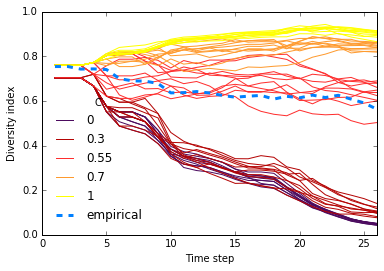

In [41]:
np.random.seed(1)
nSiumlations = 1000
nRuns = 26
xValue = np.arange(nRuns) + 1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = ["#4C0B5F", "#B40404","#FE2E2E","#FE9A2E", "#FFFF00"]
thresholdList_lim = [0, 0.3, 0.55, 0.7, 1]
c = 0
for threshold in thresholdList_lim:
    label = True
    #c = cm.hot(np.int(10*threshold)/30.,alpha = 0.3)
    for n in np.arange(nSiumlations):
        #set the model:
        model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        model.allowMixing = False
        model.conUpdate = False
        #model.autoregress = True
        model.runModel(nRuns)
        if label:#label only one instance of each threshold value
            plt.plot(xValue, model.diversityIndex, color = colors[c], label = str(threshold))
        else:
            plt.plot(xValue, model.diversityIndex, color = colors[c])
        label = False
    c = c+1
plt.plot(xValue,diversityEmpirical,'--',linewidth =3,color = "#0080FF",label = "empirical")
plt.legend(loc='lower left',frameon=False,title = "C",bbox_to_anchor=[0, 0.01])    
plt.ylim(0,1)
plt.xlim(0,26)
plt.ylabel("Diversity index")
plt.xlabel("Time step")
pp = PdfPages('figures/stabilityRegions' + '.pdf')
pp.savefig(fig)
pp.close()

### Effect of mixing

#### Effect with averaged diversities for each collaboration approach for each value of the control parameter

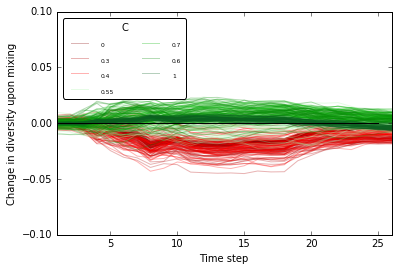

In [24]:
np.random.seed(1)
fig, ax1 = plt.subplots()
xValue = np.arange(nRuns)+1
nSim = 100
output_table_mix = np.arange(nSim)
thresholdList_lim = [0, 0.3, 0.4, 0.55, 0.7, 0.6, 1]
colors = ["#8A0808", "#B40404", "#FF0000", "#A9F5A9", "#04B404", "#088A08", "#0B6121"]
color_index = 0
improved_no_mix_case = []#this is a place holder to all mean tendencies of collaboration groups in the case of non mixing scenario
#when mixing actually improved the situation
improved_yes_mix_case = []#this is a place holder for the mean tendencies of collaboration groups in the case
#of mixing when mixing actually improved the situation
deterio_no_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# no mixing when mixing actually deteriorate the diversity of materials
deterio_yes_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# mixing when mixing actually deteriorate the diversity of materials
for threshold in thresholdList_lim:
    #c = cm.hot(np.int(10*threshold)/15,alpha = 0.4)
    c = colors[color_index]
    color_index = color_index + 1
    label = True
    diff_array = np.array([])
    for m in np.arange(50):#for each threshold there will be x diff values of the averages
        preferedColl = np.arange(nRuns)
        nonPrefernColl = np.arange(nRuns)
        for n in np.arange(nSim):#the results of the simulations will be averaged out
            #modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
            modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
            modelNotMix.condUpdate = False
            modelNotMix.allowMixing = False
            modelNotMix.runModel(nRuns)
            #modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
            modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
            modelYesMix.condUpdate = False
            modelYesMix.allowMixing = True
            modelYesMix.runModel(nRuns)
            #process results:
            preferedColl = np.vstack((preferedColl, modelNotMix.diversityIndex))
            nonPrefernColl = np.vstack((nonPrefernColl, modelYesMix.diversityIndex))
        diffVal =  np.mean(nonPrefernColl[1:, ], axis = 0) - np.mean(preferedColl[1:, ], axis = 0)
        diffVal_sum = np.sum(diffVal)
        diff_array = np.append(diff_array, diffVal_sum)
            #if np.sum(diff_array > 0) == len(diff_array):#record the mean group tendencies when mixing improved the diversity of the studied materials:
             #   improved_no_mix_case.append(modelNotMix.meanTendency)
              #  improved_yes_mix_case.append(modelYesMix.meanTendency)
            #if np.sum(diff_array < 0) == len(diff_array):#record the mean group tendencies when mixing deteriorate the diversity of the studied materials:
             #   deterio_no_mix_case.append(modelNotMix.meanTendency)
              #  deterio_yes_mix_case.append(modelYesMix.meanTendency)
        if label:#label each color only once
            ax1.plot(xValue, diffVal,color = c, alpha = 0.3, label = str(np.round(threshold,decimals = 2)))#,label = str(threshold))
            label = False
        else:
            ax1.plot(xValue,diffVal,color = c, alpha = 0.3)
    #label = False
        
    #output_table_mix = np.vstack((output_table_mix, diff_array))

plt.legend(loc="upper left", #bbox_to_anchor=[0, -0.1],
           ncol=2, shadow=False, title="C", fancybox=True,frameon=True)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.plot([1, 25], [0, 0], 'k-', lw=1)#the 1 to 1 line
plt.xlim(1,26)
plt.ylim(-0.1, 0.1)
#plt.ylim(0,1)
plt.ylabel("Change in diversity upon mixing")
plt.xlabel("Time step")

pp = PdfPages('figures/mixEffectOnDiversitydiff_mix' + '.pdf')
pp.savefig(fig)
pp.close()


### effect on diversity due to inharent stochasticity using avergae values

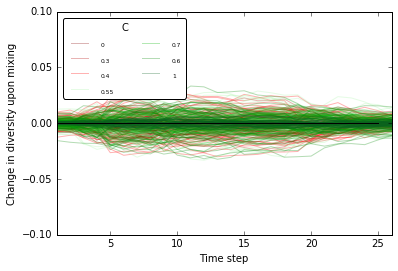

In [21]:
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
fig, ax1 = plt.subplots()
xValue = np.arange(nRuns)+1
nSim = 100
output_table_mix = np.arange(nSim)
thresholdList_lim = [0, 0.3, 0.4, 0.55, 0.7, 0.6, 1]
colors = ["#8A0808", "#B40404", "#FF0000", "#A9F5A9", "#04B404", "#088A08", "#0B6121"]
color_index = 0
improved_no_mix_case = []#this is a place holder to all mean tendencies of collaboration groups in the case of non mixing scenario
#when mixing actually improved the situation
improved_yes_mix_case = []#this is a place holder for the mean tendencies of collaboration groups in the case
#of mixing when mixing actually improved the situation
deterio_no_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# no mixing when mixing actually deteriorate the diversity of materials
deterio_yes_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# mixing when mixing actually deteriorate the diversity of materials
for threshold in thresholdList_lim:
    #c = cm.hot(np.int(10*threshold)/15,alpha = 0.4)
    c = colors[color_index]
    color_index = color_index + 1
    label = True
    diff_array = np.array([])
    for m in np.arange(50):#for each threshold there will be 10 average diff values
        preferedColl = np.arange(nRuns)
        preferedColl2 = np.arange(nRuns)
        for n in np.arange(nSim):#the results of the simulations will be averaged out
            #modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
            modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
            modelNotMix.condUpdate = False
            modelNotMix.allowMixing = False
            modelNotMix.runModel(nRuns)
            #modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
            modelNotMix2 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
            modelNotMix2.condUpdate = False
            modelNotMix2.allowMixing = False
            modelNotMix2.runModel(nRuns)
            #process results:
            preferedColl = np.vstack((preferedColl, modelNotMix.diversityIndex))
            preferedColl2 = np.vstack((preferedColl2, modelNotMix2.diversityIndex))
        diffVal =  np.mean(preferedColl2[1:, ], axis = 0) - np.mean(preferedColl[1:, ], axis = 0)
        diffVal_sum = np.sum(diffVal)
        diff_array = np.append(diff_array, diffVal_sum)
            #if np.sum(diff_array > 0) == len(diff_array):#record the mean group tendencies when mixing improved the diversity of the studied materials:
             #   improved_no_mix_case.append(modelNotMix.meanTendency)
              #  improved_yes_mix_case.append(modelYesMix.meanTendency)
            #if np.sum(diff_array < 0) == len(diff_array):#record the mean group tendencies when mixing deteriorate the diversity of the studied materials:
             #   deterio_no_mix_case.append(modelNotMix.meanTendency)
              #  deterio_yes_mix_case.append(modelYesMix.meanTendency)
        if label:#label each color only once
            ax1.plot(xValue, diffVal,color = c,alpha = 0.3, label = str(np.round(threshold,decimals = 2)))#,label = str(threshold))
            label = False
        else:
            ax1.plot(xValue,diffVal,color = c, alpha = 0.3)
    #label = False
        
    #output_table_mix = np.vstack((output_table_mix, diff_array))

plt.legend(loc="upper left", #bbox_to_anchor=[0, -0.1],
           ncol=2, shadow=False, title="C", fancybox=True,frameon=True)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.plot([1, 25], [0, 0], 'k-', lw=1)#the 1 to 1 line
plt.xlim(1,26)
plt.ylim(-0.1, 0.1)
#plt.ylim(0,1)
plt.ylabel("Change in diversity upon mixing")
plt.xlabel("Time step")
#add insets of the histograms:
#unpack all the nested lists:
#improved_no_mix_case = [val for group in improved_no_mix_case for val in group]
#improved_yes_mix_case = [val for group in improved_yes_mix_case for val in group]
#deterio_no_mix_case = [val for group in deterio_no_mix_case for val in group]
#deterio_yes_mix_case = [val for group in deterio_yes_mix_case for val in group]

#ax2 = fig.add_axes([0.7, 0.65, 0.2, 0.2])#x axis, y axis, width, height
#ax2.hist(improved_no_mix_case,label = "No mixing", color = "#B22222",normed=True, stacked = True, linewidth=0)
#ax2.hist(improved_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
#plt.xticks(fontsize=4)
#plt.yticks(fontsize=4)

#ax3 = fig.add_axes([0.7, 0.2, 0.2, 0.2])
#ax3.hist(deterio_no_mix_case, label = "No mixing", color = "#B22222",normed=True,stacked = True, linewidth=0)
#ax3.hist(deterio_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
#plt.xticks(fontsize=4)
#plt.yticks(fontsize=4)

pp = PdfPages('figures/mixEffectOnDiversitydiff_notmix' + '.pdf')
pp.savefig(fig)
pp.close()

#### The effect of mixing on tendency mean group tendencies distribution

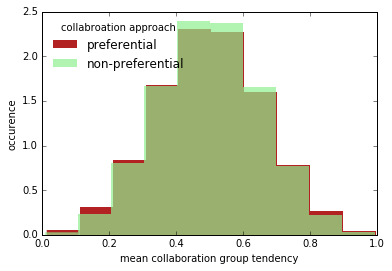

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
mean_coll_tend_nomix = []
mean_coll_tend_yesmix = []
nSIm = 1000
threshold = 0.55#threshold value has no effect on the mean collaboration tendency
for i in np.arange(nSIm):
    modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelNotMix.allowMixing = False
    modelNotMix.conUpdate = False
    modelNotMix.runModel(26)
    mean_coll_tend_nomix.append(modelNotMix.meanTendency)
    modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelYesMix.allowMixing = True
    modelYesMix.conUpdate = False
    modelYesMix.runModel(26)
    mean_coll_tend_yesmix.append(modelYesMix.meanTendency)

mean_coll_tend_nomix = [val for group in mean_coll_tend_nomix for val in group]#unpack nested lists
mean_coll_tend_yesmix = [val for group in mean_coll_tend_yesmix for val in group]

plt.hist(mean_coll_tend_nomix,label = "preferential", color = "#B22222", stacked = True, linewidth=0, normed=True)#,stacked = True)
plt.hist(mean_coll_tend_yesmix, label = "non-preferential",color = "#90EE90", stacked = True, linewidth=0, alpha = 0.7, normed=True)#,stacked = True, alpha = 0.7)
#plt.scatter(simulationStep, nomixMeanTend, color = "r")
#plt.scatter(simulationStep, yesMixMeanTend, color = "b")
plt.xlabel("mean collaboration group tendency")
plt.ylabel("occurence")
plt.legend(loc='upper left',frameon=False,title = "collabroation approach")
plt.xlim(0,1)
pp = PdfPages('figures/tendencyDist_groupAverage_hist.pdf')
pp.savefig(fig)
pp.close()

# Old code

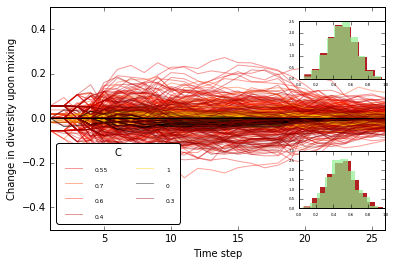

In [402]:
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
fig, ax1 = plt.subplots()
xValue = np.arange(nRuns)+1
colorIndex = np.arange(len(thresholdList))
nSim = 50
output_table_mix = np.arange(nSim)
thresholdList_lim = [0.55, 0.7, 0.6, 0.4 ,0.3,1, 0]
improved_no_mix_case = []#this is a place holder to all mean tendencies of collaboration groups in the case of non mixing scenario
#when mixing actually improved the situation
improved_yes_mix_case = []#this is a place holder for the mean tendencies of collaboration groups in the case
#of mixing when mixing actually improved the situation
deterio_no_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# no mixing when mixing actually deteriorate the diversity of materials
deterio_yes_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# mixing when mixing actually deteriorate the diversity of materials
for threshold in thresholdList_lim:
    c = cm.hot(np.int(10*threshold)/15,alpha = 0.4)
    label = True
    diff_array = np.array([])
    for n in np.arange(nSim):
        #modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        modelNotMix.condUpdate = False
        modelNotMix.allowMixing = False
        modelNotMix.runModel(nRuns)
        #modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        modelYesMix.condUpdate = False
        modelYesMix.allowMixing = True
        modelYesMix.runModel(nRuns)
        diffVal = np.array(modelYesMix.diversityIndex)-np.array(modelNotMix.diversityIndex)
        diffVal_sum = np.sum(diffVal)
        diff_array = np.append(diff_array, diffVal_sum)
        if np.sum(diff_array > 0) == len(diff_array):#record the mean group tendencies when mixing improved the diversity of the studied materials:
            improved_no_mix_case.append(modelNotMix.meanTendency)
            improved_yes_mix_case.append(modelYesMix.meanTendency)
        if np.sum(diff_array < 0) == len(diff_array):#record the mean group tendencies when mixing deteriorate the diversity of the studied materials:
            deterio_no_mix_case.append(modelNotMix.meanTendency)
            deterio_yes_mix_case.append(modelYesMix.meanTendency)
        if label:#label each color only once
            ax1.plot(xValue, diffVal,color = c,label = str(np.round(threshold,decimals = 2)))#,label = str(threshold))
        else:
            ax1.plot(xValue,diffVal,color = c)
        label = False
        
    output_table_mix = np.vstack((output_table_mix, diff_array))

plt.legend(loc="lower left", #bbox_to_anchor=[0, -0.1],
           ncol=2, shadow=False, title="C", fancybox=True,frameon=True)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.plot([1, 25], [0, 0], 'k-', lw=1)#the 1 to 1 line
plt.xlim(1,26)
plt.ylim(-0.5, 0.5)
#plt.ylim(0,1)
plt.ylabel("Change in diversity upon mixing")
plt.xlabel("Time step")
#add insets of the histograms:
#unpack all the nested lists:
improved_no_mix_case = [val for group in improved_no_mix_case for val in group]
improved_yes_mix_case = [val for group in improved_yes_mix_case for val in group]
deterio_no_mix_case = [val for group in deterio_no_mix_case for val in group]
deterio_yes_mix_case = [val for group in deterio_yes_mix_case for val in group]

ax2 = fig.add_axes([0.7, 0.65, 0.2, 0.2])#x axis, y axis, width, height
ax2.hist(improved_no_mix_case,label = "No mixing", color = "#B22222",normed=True, stacked = True, linewidth=0)
ax2.hist(improved_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

ax3 = fig.add_axes([0.7, 0.2, 0.2, 0.2])
ax3.hist(deterio_no_mix_case, label = "No mixing", color = "#B22222",normed=True,stacked = True, linewidth=0)
ax3.hist(deterio_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

pp = PdfPages('figures/mixEffectOnDiversitydiff_mix' + '.pdf')
pp.savefig(fig)
pp.close()




#### Box plot the distribtuon of change in diversity when moving from preferential to non preferentialc collaboration approach

{'boxes': [<matplotlib.lines.Line2D at 0x7f0e4cdc2be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e54d4bb38>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e4b0ccbe0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f0e5c0991d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0e4cdc2cc0>,
  <matplotlib.lines.Line2D at 0x7f0e4c504518>]}

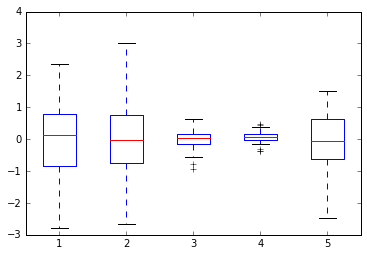

In [403]:
output_table = output_table[1:, ]
plt.boxplot(np.transpose(output_table))

#### The effect on diversity due to randomness, each two consequetive runs are substracted to see how the inharent stochasticity affect the aperant diversity 

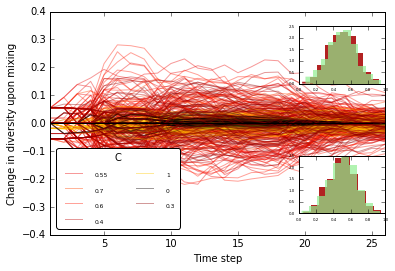

In [404]:
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
fig, ax1 = plt.subplots()
xValue = np.arange(nRuns)+1
colorIndex = np.arange(len(thresholdList))
nSim = 50
output_table_no_mix = np.arange(nSim)
thresholdList_lim = [0.55, 0.7, 0.6, 0.4 ,0.3, 1, 0]
improved_no_mix_case = []#this is a place holder to all mean tendencies of collaboration groups in the case of non mixing scenario
#when mixing actually improved the situation
improved_yes_mix_case = []#this is a place holder for the mean tendencies of collaboration groups in the case
#of mixing when mixing actually improved the situation
deterio_no_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# no mixing when mixing actually deteriorate the diversity of materials
deterio_yes_mix_case = []#this is aplace holder for the mean tendencies of the collarboartion groups in the case of
# mixing when mixing actually deteriorate the diversity of materials
for threshold in thresholdList_lim:
    c = cm.hot(np.int(10*threshold)/15,alpha = 0.4)
    label = True
    diff_array = np.array([])
    for n in np.arange(nSim):
        #modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        modelNotMix.condUpdate = False
        modelNotMix.allowMixing = False
        modelNotMix.runModel(nRuns)
        #modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelNotMix2 = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
        modelNotMix2.condUpdate = False
        modelNotMix2.allowMixing = False
        modelNotMix2.runModel(nRuns)
        diffVal = np.array(modelNotMix2.diversityIndex)-np.array(modelNotMix.diversityIndex)
        diffVal_sum = np.sum(diffVal)
        diff_array = np.append(diff_array, diffVal_sum)
        if np.sum(diff_array > 0) == len(diff_array):#record the mean group tendencies when mixing improved the diversity of the studied materials:
            improved_no_mix_case.append(modelNotMix.meanTendency)
            improved_yes_mix_case.append(modelNotMix2.meanTendency)
        if np.sum(diffVal_sum < 0) == len(diff_array):#record the mean group tendencies when mixing deteriorate the diversity of the studied materials:
            deterio_no_mix_case.append(modelNotMix.meanTendency)
            deterio_yes_mix_case.append(modelNotMix2.meanTendency)
        if label:#label each color only once
            ax1.plot(xValue, diffVal,color = c,label = str(np.round(threshold,decimals = 2)))#,label = str(threshold))
        else:
            ax1.plot(xValue,diffVal,color = c)
        label = False
        
    output_table_no_mix = np.vstack((output_table_no_mix, diff_array))

plt.legend(loc="lower left", #bbox_to_anchor=[0, -0.1],
           ncol=2, shadow=False, title="C", fancybox=True,frameon=True)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.plot([1, 25], [0, 0], 'k-', lw=1)#the 1 to 1 line
plt.xlim(1,26)
plt.ylim(-0.4,0.4)
#plt.ylim(0,1)
plt.ylabel("Change in diversity upon mixing")
plt.xlabel("Time step")
#add insets of the histograms:
#unpack all the nested lists:
improved_no_mix_case = [val for group in improved_no_mix_case for val in group]
improved_yes_mix_case = [val for group in improved_yes_mix_case for val in group]
deterio_no_mix_case = [val for group in deterio_no_mix_case for val in group]
deterio_yes_mix_case = [val for group in deterio_yes_mix_case for val in group]

ax2 = fig.add_axes([0.7, 0.65, 0.2, 0.2])#x axis, y axis, width, height
ax2.hist(improved_no_mix_case,label = "No mixing", color = "#B22222",normed=True, stacked = True, linewidth=0)
ax2.hist(improved_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

ax3 = fig.add_axes([0.7, 0.2, 0.2, 0.2])
ax3.hist(deterio_no_mix_case, label = "No mixing", color = "#B22222",normed=True,stacked = True, linewidth=0)
ax3.hist(deterio_yes_mix_case, label = "With mixing", color = "#90EE90", alpha = 0.7, normed=True,stacked = True, linewidth=0)
plt.xticks(fontsize=4)
plt.yticks(fontsize=4)

pp = PdfPages('figures/mixEffectOnDiversitydiff_no_mix' + '.pdf')
pp.savefig(fig)
pp.close()


{'boxes': [<matplotlib.lines.Line2D at 0x7f0e4d27c8d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e4d256e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e4d264a90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f0e4d264160>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0e4d27cb38>,
  <matplotlib.lines.Line2D at 0x7f0e4d263e80>]}

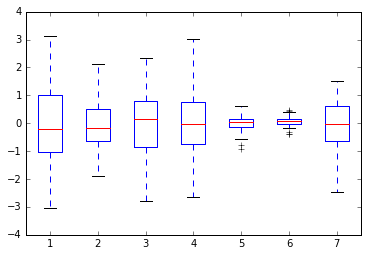

In [377]:
output_table = output_table[1:, ]
plt.boxplot(np.transpose(output_table))

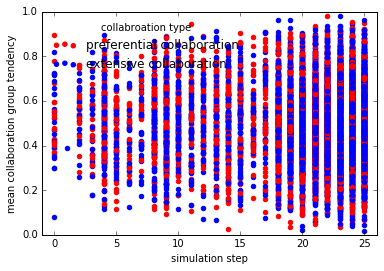

In [442]:
threshold = 0.5
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nSIm = 20
nomixMeanTend = []
yesMixMeanTend = []
simulationStep = []
for i in np.arange(nSIm):
    modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelNotMix.allowMixing = False
    modelNotMix.conUpdate = False
    modelNotMix.runModel(26)
    #nomixMeanTend.append(modelNotMix.meanTendency)
    if i== 0:
        plt.scatter(modelNotMix.simulationstepCounter, modelNotMix.meanTendency, color = "r", label = "preferential collaboration")    
    else:
        plt.scatter(modelNotMix.simulationstepCounter, modelNotMix.meanTendency, color = "r")
    modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelYesMix.allowMixing = True
    modelYesMix.conUpdate = False
    modelYesMix.runModel(26)
    #yesMixMeanTend.append(modelYesMix.meanTendency)
    #simulationStep.append(modelYesMix.simulationstepCounter)
    if i == 0:
        plt.scatter(modelYesMix.simulationstepCounter, modelYesMix.meanTendency, color = "b", label = "extensive collaboration")
    else:
        plt.scatter(modelYesMix.simulationstepCounter, modelYesMix.meanTendency, color = "b")
    
#plt.scatter(simulationStep, nomixMeanTend, color = "r")
#plt.scatter(simulationStep, yesMixMeanTend, color = "b")
plt.xlabel("simulation step")
plt.ylabel("mean collaboration group tendency")
plt.legend(loc='upper left',frameon=False,title = "collabroation type")
plt.xlim(-1,26)
plt.ylim(0,1)
pp = PdfPages('figures/tendencyDist_groupAverage.pdf')
pp.savefig(fig)
pp.close()

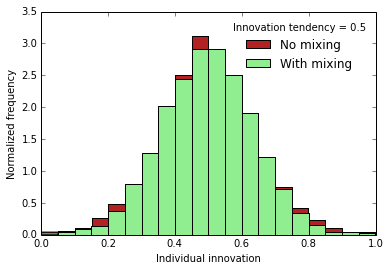

In [203]:
nSIm = 50
threshold = 0.5
tendCurrNoMix = []
for n in np.arange(nSIm):
    modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelNotMix.allowMixing = False
    modelNotMix.conUpdate = False
    modelNotMix.runModel(26)
    for key in modelNotMix.agents_attribute.keys():
        val = modelNotMix.agents_attribute[key]["current tendency"]
        if type(modelNotMix.agents_attribute[key]["current tendency"]) == np.ndarray:
            val = np.double(val)
        tendCurrNoMix.append(val)
tendCurrYesMix = []
for n in np.arange(nSIm): 
    modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10, weights)
    modelYesMix.allowMixing = True
    modelYesMix.conUpdate = False
    modelYesMix.runModel(26)
    for key in modelYesMix.agents_attribute.keys():
        val = modelYesMix.agents_attribute[key]["current tendency"]
        if type(modelYesMix.agents_attribute[key]["current tendency"]) == np.ndarray:
            val = np.double(val)
        tendCurrYesMix.append(val)
        
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(tendCurrNoMix,label = "No mixing",bins = 20,color = "#B22222",normed=True,stacked = True)
plt.hist(tendCurrYesMix, label = "With mixing",bins = 20,color = "#90EE90",normed=True,stacked = True)
plt.legend(loc='upper right',frameon=False,title = "Innovation tendency = " + str(threshold))
plt.xlabel("Individual innovation")
plt.ylabel("Normalized frequency")
pp = PdfPages('figures/tendencyDist' + '.pdf')
pp.savefig(fig)
pp.close()


#### Old calibration parameters

In [3]:
#Calibration parameters:
pmTypes = 90#there are 90 types of PM in the experiemntal network
domTypes = 123#there are 123 types of DOM in the experimental network
nExprerYear = np.array([])#an array with number of experiments per year 
expGrowthFactor = 2#or the factor by which the number of
#experiments is increasing in each year..
nAgents = 4#number of researchers the initial number of researchers should be the same as the size of the collaboration group
collSize = 4#the average number of researchers in a collaboration group (average number of coauthors on a paper in the database)
nAgents = nAgents - nAgents%collSize#make sure the agents can be split to euqal groups of size 'collSize'
threshold = 0.5#threshold from which above the tendency is to repeat studied combinations 
####################################
#Empirical input:
####################################
#intial conditions at the begining of the 1990, 48 comb were studied: 45 combinations were studied ones and 3 combinations were studied 2
studiedComb = np.array([32,4,1,1])#the number of combinations studied till 1990 (overall 38 comb)
studiedTimes = np.array([1,2,4,7])#the number of times each combination was repeated (overall 51 experiments)
#for each age, how likely is the agent to die? from age of 1 to the age of 9 (after 1 time step, after 9 time steps)
#assuming no one can survive after time step 9
lifeExpect = np.array([0.866336634,0.049504950,0.032178218,0.021039604,0.012376238,0.003712871,0.008663366,0.004950495,0.001237624])
#for each age, how likely is the agent to die? from age of 1 to the age of 9 (after 1 time step, after 9 time steps)
#assuming no one can survive after time step 9
#lifeExpect = scipy.stats.expon.pdf(np.arange(1,30), scale=1/0.5)#the life expectency is assumed to follow 
#exponential distribution with rate parameter of 1/0.5 (in R it's just 0.5)
#lifeExpect = lifeExpect/np.sum(lifeExpect)#convert to a probability that sums up to 1
nRuns = 26
#empirical number of new agents each year starting from 1991, since the nAgnet is the nuber in 1990
newAgents = np.array([0,3,7,15,3,6,6,11,23,8,6,7,11,12,8,3,14,43,53,63,59,72,136,117,103])#Here assuming the addition
#at 1991 is the same as 1990 an the array is assumed to start from 1991
#newAgents = np.cumsum(np.arange(0,20))
diversityEmpirical = np.array([0.8000000,0.8000000,0.7878788,0.7894737,0.7735849,0.7321429,0.7203390,0.7177419,\
                               0.7022901,0.6951220,0.6941176,0.6961326,0.6885246,0.6718750,0.6616162,0.6837209,0.6863636,\
                               0.6652542,0.6754717,0.6666667,0.6716792,\
                               0.6572052,0.6545106,0.6373984,0.6159317,0.5869297])

In [ ]:
class materialChoice:
    """This is a class object used to model the choice of materials in the experiemntal field that investigated
    the effect of DOM on PM"""
    #def __init__(self, nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, nExpr, nCharac,\
     #            studiedComb = studiedComb, studiedTimes = studiedTimes, studiedCombWeights = weights):
    def __init__(self, nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, nExpr, nCharac,\
             studiedCombWeights):
        """The initialization function that sets the main attributes of the model object (calibration attribute)
        'nAgents' = number of agents at the begining of the simulation
        'pmTypes' = number of the main experimental components types (e.g. engineered nanoparticles types)
        'domTypes' = number of the secondery experimental components types (e.g. dissolved organic matter or test organism)
        'collSize' = number of coauthors on a paper / number of researches in a collaboration group
        'lifeExpect' = the weibull distribution parameter indicating what are the chances of leaving the field given the
        years of activity
        'newAgents' = the number of new researchers entering the field in each year
        'threshold' = the community threshold for innovation
        'studiedComb' = the number of combinations studied for each amount of repetition as given below, for example
        if the studiedComb[0] = 32 and studiedTimes[0] = 1, it means that by the start of the simulation there were
        32 combinations studied each one only once
        'n_expr' = the number of experiments done per paper
        'n_charac' = the number of charachterization methods available for each main component (potentially)
        studiedCombWeights = initial weights distribution at the begining of the simuation
        """
        #agents related intialization values:
        if nAgents != collSize:
            nAgents = collSize#in case the inital number of agents cannot construct a group, the code sets that number
        #to the size of a collaboration group!
            #print("I adjusted number of initial agents to the size of the collaboration group")
        self.nAgents = nAgents
        self.collSize = collSize
        self.lifeExpect = lifeExpect#a probability array
        self.newAgents = newAgents#the list of the empirical number of agents added in each year
        self.allowMixing = False#should newcomers pair up with existing researchers? as a default is set to false,,
        self.condUpdate = True#conditional update as a default agents update their opinion is their materials choice was relevant,
        self.InnovNoise = 0.05#this value defines likelihood of conservative collaboration group to still explore new materials
       
        #materials related initialization values:
        self.pmTypes = pmTypes
        self.domTypes = domTypes       
        self.threshold = threshold
        #self.studiedComb = studiedComb#empirical values of how many and how often combinations were studied before the simulation started
        #self.studiedTimes = studiedTimes
        self.studiedCombWeights = studiedCombWeights
        self.nCharac = nCharac#number of characterization protocols
        self.memory = False #should materials be picked up for innovation using memory?
        self.nExperiments = nExpr#the number of experiments to be chosen by each collaboration group
        #which accounts for the possibility of other factors that determine the choice of materials that are not explicitly
        #accounted for in the model.
        #however this can be changed after model initialization and the agents 
        #after the model instance is initiated it can be set otherwise (before runModel() is called)
        self.autoregress = False#if true then the choice of materials is influenced by the most recent year choice
        #of materials.
        #
        #Initialize properties based on the object function
        self.countExpr = 0
        #self.setCollaboComb()#a list of touples with the combinations of indeces of agents in a collaboration group,
        #later used to create the collaboration network
        self.setAgentAttrib(init = True)#assigns the tendency to repeat materials of each agent
        self.allMaterialsComb()#creates a large array of all materials combinations
        self.initExpCharach()#a place holder to contain the experimental settings reported for the main
        #constituent 
        #self.setCollGroup(np.arange(self.nAgents),init=True)
        self.setCollGroupInit(np.arange(self.nAgents))
        self.diversityIndex = []#will accumulate the diveristy index of the materials investigated
        self.meanTendency = []#the mean tendency of agents
    def setAgentAttrib(self,agentsToAdd = 0,init = False):
        """This function creats a dictionary structure for the model object, where each key is an agent
        agents are identified by their position on the grid i.e: 'cellx-coly and sets the initial attribue of each agent
        The function either initialize the dictionary of agents attribute or adds new agents to the already existing
        dictionary"""
        if init:
            self.agents_attribute = {}#the agents dictionary
            toAdd = np.arange(self.nAgents)#the indices of the agents to be added if the function was alreay initialized 
        else:
            toAdd = np.arange(self.nAgents,self.nAgents + agentsToAdd)#if this is not the first inialization, then arrange
            #the new added agents in an array
        self.nAgents = self.nAgents + agentsToAdd#update the number of agents
        for agent in toAdd:#cell[0] - row of the agent and cell[1] - col of the agent
                self.agents_attribute[str(agent)] = {}#for each agenta n intial dictionary is set
                self.agents_attribute[str(agent)]["baseline tendency"] = np.random.random(1)#a random number between 0 and 1
                #from a uniform distribution
                self.agents_attribute[str(agent)]["current tendency"] = self.agents_attribute[str(agent)]["baseline tendency"]
                #the average tendency of the current collaboration group
                self.agents_attribute[str(agent)]["collaboraton tendency"] = self.agents_attribute[str(agent)]["baseline tendency"]
                #self.agents_attribute[str(agent)]["PM studied"] = []
                #self.agents_attribute[str(agent)]["DOM studied"] = []
                self.agents_attribute[str(agent)]["comb studied"] = []#the combinations studied in each time step,
                #a nested list
                self.agents_attribute[str(agent)]["collaborators"] = []#the collaborators with whome the agent
                #was assigned to the exact same collaboration group, also a nested list
                self.agents_attribute[str(agent)]["age"] = 0#the age of the agent, which will determine his likelihood to die as
                #time progresses
                self.agents_attribute[str(agent)]["state"] = "alive"#is the agent dead or alive? alive agents
                #are active researchers, dead agents are not active researchers
        return(toAdd)
    def allMaterialsComb(self):
        """This function creates an array of all possible DOM and PM types (where number of types are given from 
        empirical data) and creates arrays of weights for PM and DOM"""
        self.allComb = np.zeros((1,3))#an array of three columns, the first is the PM type, the second
        #is the DOM type, the third is the weight:
        self.allComb_id = []#a list of all cmobinations in a string form: "pm-dom" to enable easier extraction later on
        for pm in np.arange(self.pmTypes):
            for dom in np.arange(self.domTypes):
                self.allComb = np.vstack((self.allComb,np.array([pm,dom,0])))
                self.allComb_id.append(str(np.double(pm)) + "-" + str(np.double(dom)))
        #remove the first row, which contains the [0,0,0] that were used to initialize the model:
        self.allComb = np.delete(self.allComb,1,axis = 0)#remove the first row (axis zero)
        self.allComb_id = np.array(self.allComb_id)#convert into np array for easier indexing
        #self.comProb = np.zeros((np.shape(self.allComb)[0],))# the forth is the probability of choosing the given comb
        #
        #add the initial conditions presented before the simulation started (in 1990): we arbitrarily update the first
        #38 combinations, as the actual combinations in the simulations have no meaning by themselves
        #startPoint = 0
        #for comb in np.arange(len(self.studiedComb)):
         #   self.allComb[startPoint:(startPoint + self.studiedComb[comb]),2] = self.studiedTimes[comb]#adding weight of 1 to comb studied once before 1990
          #  startPoint = startPoint + self.studiedComb[comb]#update the starting point such that we take consequtive combinations
        self.allComb[:, 2] = self.studiedCombWeights
        #the following creates an array for each DOM and PM constituents and it will store the number of times each material
        #was used sequencially in the model simulation
        self.domProb = np.ones(self.domTypes)
        self.pmProb = np.ones(self.pmTypes)
        #Feel the array with the weights (number of times a material was used) in the intial conditions:
        for dom in np.arange(self.domTypes):
            self.domProb[dom] = self.domProb[dom] + np.sum(self.allComb[self.allComb[:, 1] == dom, 2])
        for pm in np.arange(self.pmTypes):
            self.pmProb[pm] = self.pmProb[pm] + np.sum(self.allComb[self.allComb[:, 0] == pm, 2])
    def initExpCharach(self):
        """This function initialize a dictionray for the characterization protocols of the main component
        of the experiment"""
        self.exprCharc = {}
        for i in np.arange(self.pmTypes):
            self.exprCharc[i] = np.ones(self.nCharac)
        #update the protocols for the initial experiments done before the simulation started:
        #for w in self.allComb[np.where(self.allComb[:, 2] > 0)[0], 0]:
         #   mainComp = np.int(w)
          #  self.exprCharc[mainComp] = self.exprCharc[w] + self.allComb[mainComp, 2]
    def setCollaboComb(self):
        """This function returns the combinations of indeces of agents in a collaboration group of size self.collSize
        in order to create the collaboration network"""
        indexComb = []
        for i in np.arange(self.collSize):
            for j in np.arange(i+1,stop = self.collSize):
                indexComb.append((i,j))
        self.indexComb = indexComb
    def setCollGroupInit(self, arrayAgents, tStep = 0):
        """
        This function sets the collaboration group for the first group of researchers
        """
        if tStep == 0 or len(self.collGroups) == 0:
            self.collGroups = np.repeat(-1, self.collSize)
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) >= self.collSize:#if the agents cannot be split into even collaboration groups
            fitToSplit = arrayAgents[:len(arrayAgents) - len(arrayAgents)%self.collSize]#the agents that can be split evenly into collaboration groups of size: self.collSize
            remainder = arrayAgents[-1*(len(arrayAgents)%self.collSize):] #create a collaboration group with dummy agents
            remainder = np.append(remainder, np.repeat(-1, self.collSize-len(remainder)))#fill in the remainder with dummy agents
            collGroups = np.split(np.random.choice(fitToSplit, len(fitToSplit), replace = False),\
                                   len(fitToSplit)/self.collSize)
            if len(self.collGroups) == 0:
                self.collGroups = collGroups
            else:
                self.collGroups = np.vstack((self.collGroups, collGroups))
            self.collGroups = np.vstack((self.collGroups, remainder))
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) < self.collSize:
            #if there is only one/two agent in the group to be reassigned just reassiged them to a group again
            #and return to exit this function
            lonelyGroup = np.append(arrayAgents,np.repeat(-1,self.collSize-len(arrayAgents)))
            if len(self.collGroups) == 0:
                self.collGroups = lonelyGroup
            else:
                self.collGroups = np.vstack((self.collGroups, lonelyGroup))
        if len(arrayAgents)%self.collSize == 0:#if the number of agents is devisible by the size of the collaboration group
            fitToSplit = arrayAgents
            collGroups = np.split(np.random.choice(fitToSplit,len(fitToSplit),replace = False),\
                                   len(fitToSplit)/self.collSize)
            if len(self.collGroups) == 0:
                self.collGroups = collGroups
            else:
                self.collGroups = np.vstack((self.collGroups, collGroups))
        #if tStep == 0:
         #   self.collGroups = self.collGroups[:][1:]
    def setCollGroup(self, agentsExisting, agentsNew):
        """
        This function sets the collaboration groups with the agents for all time steps other than time step 0
        It takes as arguments the list of existing agents that need reassignment and a list of newcommers.
        If the self.mix argument is set to true it mixes the existing and new agents.
        Else, it creates collaboration groups with exisitng agents and collaboration groups with newcomers.
        In case of such seperation, the exisitng agents are mixed preferably with collborators with whome they
        collaborated in the past.
        """
        #take only the agents that are "alive" (from the existing agents, the new agents are always set to "alive" as a defualt)
        aliveArray = np.zeros(0)#a place holder for the accumulation of living agents 
        for agent in agentsExisting:
            if agent != -1:#if it's a real agent
                if self.agents_attribute[str(agent)]["state"] == "alive":
                    aliveArray = np.append(aliveArray,agent)
        aliveArray = aliveArray.astype("int")#change the agents that are being assigend to groups now only to living ones
        #in case all agents died there is no collaboration group
        if self.allowMixing:
            #If mixing is allowed between newcomers and existing agents
            allAgents = np.append(aliveArray, agentsNew)
            self.setCollGroupInit(allAgents, tStep = 1)#
            return()
        if not self.allowMixing:
            #If mixing is not allowed between newcomers and existing agents
            existingAgents_nocoll = np.array([]) #those are agents that are not new, but have no prefered collaborators, will
            #be grouped with new agents:
            for a in aliveArray:
                if len(self.agents_attribute[str(a)]["collaborators"]) == 0:
                    agentsNew = np.append(agentsNew, a)    
                    aliveArray = np.delete(aliveArray, np.where(aliveArray == a)[0][0])
            self.setCollGroupInit(agentsNew, tStep = 1)#creates groups for new comers seperately
            #create groups of existing agents alone, with preference to collaborate with people they already
            #collaborated in the past with:
            if len(aliveArray) == 0:#if all exsiting agets died, return()
                return()
            if len(aliveArray) <= self.collSize:#if the number of agents for reassignment is smaller than
                    #or equal to the collaboration group size
                    #append them all to one remainer collaboration gruop with palce holders, 
                    #they won't participate in the next round
                    remainder = np.append(aliveArray, np.repeat(-1,self.collSize-len(aliveArray)))
                    self.collGroups = np.vstack((self.collGroups,remainder))
                    return()
            while len(aliveArray) > 0:#while we still have agents to reassign and they are more than one group in size
                    currentAgent = aliveArray[0]#take the first agent in the arrayAgent
                    aliveArray = np.delete(aliveArray, np.where(aliveArray == currentAgent)[0][0])#delete the first agent
                    collGroup = np.array([currentAgent])
                    preferedCollFirstDegree = self.agents_attribute[str(currentAgent)]["collaborators"][0]#obtain its perfered collaborators
                    for i in preferedCollFirstDegree:
                        if not i in aliveArray:
                            continue#if the prefered colaborator is not in the array of agents to be reassigned then skipped her
                        if len(collGroup) < self.collSize:#if we still less then the collaboration grup size
                            collGroup = np.append(collGroup, i)
                            aliveArray = np.delete(aliveArray, np.where(aliveArray == i)[0][0])#remove this agent from the list
                        if len(collGroup) < self.collSize:#if we still need new agents to create the collaboration
                            preferedCollFirstDegree = self.agents_attribute[str(i)]["collaborators"][0]#the prefered collaborators of
                            #the agents that is himself the prefered collaborator of the analyzed agent
                            for j in preferedCollFirstDegree:
                                if j in aliveArray and len(collGroup) < self.collSize:
                                    collGroup = np.append(collGroup, j)
                                    aliveArray = np.delete(aliveArray, np.where(aliveArray == j)[0][0])
                        if len(collGroup) < self.collSize:#if we still didn't fill all the required number of agents
                            if len(aliveArray) >= self.collSize-len(collGroup):
                                collGroup = np.append(collGroup, aliveArray[0:self.collSize-len(collGroup)])
                                aliveArray = aliveArray[(self.collSize-len(collGroup)):]
                            else:#if there are not enough agents in the agets array to make this a full collaboration group
                                #add them and fill the rest with minus ones
                                collGroup = np.append(collGroup, aliveArray)
                                collGroup = np.append(collGroup, np.repeat(-1,self.collSize-len(collGroup)))
                                aliveArray = np.array([])
                        #finally append the colaboration group to the list of all collaborations:
                        self.collGroups = np.vstack((self.collGroups,collGroup))
    
    def setCollGroup_old(self,arrayAgents,init = False):
        """This function sets the collabotation groups with the agents, sets collaboration based on the average number of 
        authors per paper. Picks agents at random and assigns them to available agents, provided
        they dont already collaborate with someone. The argument arrayAgents is an array of agents' indices
        that need to be assigned to a collaboration group, either all agents (when model is initialized)
        or array of agents that broke their collaboration groups and should be reassigned (since once a collaboration
        group is broken the agents whom need reassignment has to be dividble by the collSize argument)
        if this is the first initialization of groups then they are assigned to collGroups attribute, else they
        are stacked with the existing groups that were not disassembled"""
            #split the agents into groups of 3, but first shuffle them since we don't want to have path dependncy
            #affected by neighbouring indices
        #take only the agents that are "alive":
        aliveArray = np.zeros(0)#a place holder for the accumulation of living agents 
        for agent in arrayAgents:
            if agent != -1:#if it's a real agent
                if self.agents_attribute[str(agent)]["state"] == "alive":
                    aliveArray = np.append(aliveArray,agent)
        arrayAgents = aliveArray.astype("int")#change the agents that are beign assigend to groups now only to living ones
        #in case all agents died there is no collaboration group
        if len(arrayAgents) == 0:
            return()
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) >= self.collSize:#if the agents cannot be split into even collaboration groups
            fitToSplit = arrayAgents[:len(arrayAgents) - len(arrayAgents)%self.collSize]#the agents that can be split evenly into collaboration groups of size: self.collSize
            remainder = arrayAgents[-1*(len(arrayAgents)%self.collSize):]
        if len(arrayAgents)%self.collSize != 0 and len(arrayAgents) < self.collSize:
            #if there is only one/two agent in the group to be reassigned just reassiged them to a group again
            #and return to exit this function
            lonelyGroup = np.append(arrayAgents,np.repeat(-1,self.collSize-len(arrayAgents)))
            self.collGroups = np.vstack((self.collGroups,lonelyGroup))
            return()  
        if len(arrayAgents)%self.collSize == 0:#if the number of agents is devisible by the size of the collaboration group
            fitToSplit = arrayAgents
            remainder = 0
        #print(arrayAgents)
        if init:
            self.collGroups = np.split(np.random.choice(fitToSplit,len(fitToSplit),replace = False),\
                                   len(fitToSplit)/self.collSize)
            self.collAdjacenyList = []#an adjacency list place holder, for the collaboration network. This is a list of
            #touples of colaborating agents.
            for group in self.collGroups:
                for agentpair in self.indexComb:
                    self.collAdjacenyList.append((group[agentpair[0]],group[agentpair[1]]))
        else: #if there are already some groups created in previous time steps and that were not disassembled
            newGroups = np.split(np.random.choice(fitToSplit,len(fitToSplit),replace = False),\
                                   len(fitToSplit)/self.collSize)
            
            self.collGroups = np.vstack((self.collGroups,newGroups))
            for group in newGroups:
                for agentpair in self.indexComb:
                    self.collAdjacenyList.append((group[agentpair[0]],group[agentpair[1]]))
        if type(remainder) != int:#if the number of agents didn't divide by the collaboration size, add the remainder agents 
            #as a seperate group.
            #since the size has to be of self.collSize in order to be stacked, we add -1 as place holder to match
            #the array size, and later on these numbers will not be treated as agents
            remainder = np.append(remainder,np.repeat(-1,self.collSize-len(remainder)))
            self.collGroups = np.vstack((self.collGroups,remainder))
    def calcGruopTend(self,group):
        """for the given collaboration group ('group' argument) this function calculates the tendency to repeat
        materials in experiments"""
        tendency = 0
        lenGroup = 0#number of real agents, such that if there is -1 (a palce holder) it won't be counted
        for i in np.arange(len(group)):
            if group[i] != -1:
                tendency = tendency + self.agents_attribute[str(group[i])]["current tendency"]
                lenGroup = lenGroup + 1#count the number of real agents
        return(np.double(tendency/lenGroup))#return the average tendency of the current group
    def updateCollaborationListMaterials(self,group,comb):
        """This function updates the list of collaborators and materials used for the given time step for every agent,
        where group is the currently analyzed collaboration group and comb is a list of rows indicating the
        DOM-PM combinations analyzed in this time step by the given group"""
        combList = []
        for j in comb:
            combList.append(str(self.allComb[j,0]) + "-" + str(self.allComb[j,1]))
        for i in np.arange(len(group)):
            if group[i] != -1:
                self.agents_attribute[str(group[i])]["comb studied"].append(combList)#append the list of material
                #combinations studied for the given collaboration group to each one of it's members
                collaborators = list(np.delete(group,i))#all other collaborators in the given group except for the given agent
                self.agents_attribute[str(group[i])]["collaborators"].append(collaborators)
    def updateCmobStudied(self, group, comb):
        """
        Update the combiantions studied for each memeber of a collaboration group
        """
        combList = []
        for j in comb:
            combList.append(str(self.allComb[j,0]) + "-" + str(self.allComb[j,1]))
        for i in np.arange(len(group)):
            if group[i] != -1:
                self.agents_attribute[str(group[i])]["comb studied"].append(combList)#append the list of material
                #combinations studied for the given collaboration group to each one of it's members
    def updateCollaborationList(self, group):
        """
        Update the collaboration conncetions
        """
        for i in np.arange(len(group)):
            if group[i] != -1:
                collaborators = list(np.delete(group,i))#all other collaborators in the given group except for the given agent
                self.agents_attribute[str(group[i])]["collaborators"].append(collaborators)
    def calcMaterialsProb(self):
        """This function calculates the probability of choosing a given PM-DOM combination based on the weight
        of their respective row"""
        rows = np.where(self.allComb[:,2] != 0)[0]#the indices of rows that have weight != 0 (combinations that were studied in the past)
        increasePrevelance = self.allComb[rows,2]**2#more emphasis on highly studied combinations
        prob = increasePrevelance/sum(increasePrevelance)
        #prob = self.allComb[rows,2]/sum(self.allComb[rows,2])#the probability of choosing this row (only considering rows 
        #that have weight > 0)
        self.comProb[rows] = prob#assign the given probabilities to the respective rows, this step is updated in each simulation rum
    def chooseMaterialNoPref(self):
        """This function chooses materials combinations for those collaboration groups that have tendency below
        self.thereshold (will not repeat), that is, there is no preferance regarding the weight of links of the
        possible combinations"""
        if np.random.binomial(n = 1,p = 0.5):#the probability to study either PM or DOM as the main material
            #choose one PM and test it with x number of DOM based on the empirical probability
            nDOM = 4#the avergae number of DOM types each PM is studied with, (later will be drawn from empirical probability)
            pm = np.int(np.random.choice(np.arange(self.pmTypes),size=1))#sample a pm randomly
            expConditons = np.random.choice(np.where(self.allComb[:,0] == pm)[0],size =nDOM,replace=False)#find corresponding ROWS DOM in 
            #a combination with the same PM as 'pm'
        else:#the main material to be studied in DOM
            nPM = 4#the avergae number of PM types a given DOM is studied with (later will be drawn from empirical probability)
            dom = np.int(np.random.choice(np.arange(self.domTypes),size=1))#sample a DOM randomly
            expConditons = np.random.choice(np.where(self.allComb[:,1] == dom)[0],size = nPM,replace=False)#find corresponding ROWS DOM in 
                #a combination with the same PM as 'pm'
        return(expConditons)#the row numbers with the chosen material combinations
    def chooseMateiralRestrictedInnov(self):
        """
        This function chooses materials for the innovation case. It doesn't choose combiantions at random, but rather
        diversify the 
        """
        if np.random.binomial(n = 1,p = 0.5):#choose to focus either on the first experimental constituent (first column)
    #or the second experimental constituent (second column of self.allComb)
            const = 0
            const1Id = np.arange(self.pmTypes)
        else:
            const = 1
            const1Id = np.arange(self.domTypes)
            
        const1Count = np.bincount(self.allComb[:, const].astype('int'), self.allComb[:, 2])#the weights of the
        const1Count = const1Count/np.sum(const1Count)#convert to empirical probabilities
        #const1Id = np.unique(model.allComb[:, const].astype('int'))
        #const1Id = np.arange(self.domTypes)
        #print(len(const1Id))
        #print(len(const1Count))
        chosenConst1 = np.random.choice(const1Id, size = self.nExperiments, replace = True, p = const1Count)#sample a pmrandomly
        lines = []# alist of rows of material combinations for mateiral that was tested often
        for i in chosenConst1:
            line = int(np.random.choice(np.where(self.allComb[:, 1] == i)[0], size = 1))
            while line in lines:#make sure that the same group doesn't chech the same combination in the same experiment more than once
                line = np.random.choice(np.where(self.allComb[:, 1] == i)[0], size = 1)
            lines.append(line)
        return(lines)
    def chooseMaterialNoPref2(self):
        """This function chooses materials combinations for those collaboration groups that have tendency below
        self.thereshold (will not repeat), that is, there is no preferance regarding the weight of links of the
        possible combinations and rows are sampled randomly so same PM or DOM are not guranteed"""
        expConditons = np.random.choice(np.arange(np.shape(self.allComb)[0]),size =self.nExperiments,replace=False)#find corresponding ROWS DOM in 
            #a combination with the same PM as 'pm'
        return(expConditons)#the row numbers with the chosen material combinations
    def chooseMaterialWithPref(self):
        """This function chooses materials for repetitive researchers, that is more likely to sample rows that have
        higher weight"""
        rows = np.where(self.allComb[:,2] != 0)[0]
        #print(rows)
        comChosen = np.random.choice(rows,size=1,p = self.comProb[rows],replace = False)
        if np.random.binomial(n = 1,p = 0.5):#the probability to study either PM or DOM as the main material
            #choose one PM and test it with x number of DOM based on the empirical probability
            nDOM = 4#the avergae number of DOM types each PM is studied with, (later will be drawn from empirical probability)
            pm = self.allComb[comChosen,0]#the pm that was chosen
            relevRows = np.where(self.allComb[:,0] == pm)[0]#the row numbers where this PM appears
            prob = self.allComb[relevRows,2] + 1#adding one to each link to be able to consider all of them
            prob = prob/sum(prob)
            expConditons = np.random.choice(relevRows,size = nDOM,replace = False,p = prob)#find corresponding ROWS DOM in 
            #a combination with the same PM as 'pm'
        else:#the main material to be studied in DOM
            nPM = 4#the avergae number of PM types a given DOM is studied with (later will be drawn from empirical probability)
            dom = self.allComb[comChosen,1]#the DOM that was chosen
            relevRows = np.where(self.allComb[:,1] == dom)[0]
            prob = self.allComb[relevRows,2] + 1
            prob = prob/sum(prob)
            expConditons = np.random.choice(relevRows,size = nPM,replace = False,p = prob)#find corresponding ROWS DOM in 
        return(expConditons)
    def chooseMaterialWithPref2(self):
        """This function chooses materials for repetitive researchers,
        that is more likely to sample rows that have higher weight. However, unlike the original function
        with the same name, this one sampls rows based on their weight, but it doesn't gurentee to sample rows that
        have the same PM or DOM, that is repetition of one material within a single experiment is not guaranteed """
        rows = np.where(self.allComb[:,2] != 0)[0]#all rows that have weight larger than 0
        #prob = np.copy(self.allComb[rows,2] + 1)
        prob = np.copy(self.allComb[rows,2])
        prob = prob/np.sum(prob)#probability of choosing a row that has a weight larger than zero
        expConditons = np.random.choice(rows,size=self.nExperiments, p = prob,replace = False)#choose rows based on the weight probability
        return(expConditons)
    def chooseMaterialWithPref2_autoregg(self, lastYearMaterials):
        """This function chooses materials for repetitive researchers,
        that is more likely to sample rows that have higher weight (based on data from last year). However, unlike the original function
        with the same name, this one sampls rows based on their weight, but it doesn't gurentee to sample rows that
        have the same PM or DOM, that is repetition of one material within a single experiment is not guaranteed """
        rows = np.where(lastYearMaterials[:,2] != 0)[0]#all rows that have weight larger than 0
        #print(lastYearMaterials)
        #prob = np.copy(self.allComb[rows,2] + 1)
        prob = np.copy(lastYearMaterials[rows,2])
        prob = prob/sum(prob)#probability of choosing a row that has a weight larger than zero
        expConditons = np.random.choice(rows,size=self.nExperiments,p = prob,replace = False)#choose rows based on the weight probability
        return(expConditons)

    def chooseComb_memory(self, group, pref = False):
        """This function chooses materials to study for a given group that involves a constituents that 
        they already studied before and the counter parts from the possible counterparts from ones that
        were studied by others more often in the past. If there is a preference than the counter constituent
        chosen is the chosen based on its weight, else the counter constituent is chosen uniformly at random 
        from the possible ones. This ensures that regarless of the tendency there is always an anchor to the previous experiments
        which creates a bias towards one constituent - so researchers are not entirely free unless they all enter the field and
        without previous memeory, then they choose antire combinations uniformly at random"""
        const_array = np.array([])#an array that will acumulate either pm or dom constituents that were studied perviously
        #by the researchers in the given collaborating group
        i = np.random.binomial(n=1, p = 0.5)# i=0 the PM constituent will be accumulated, i = 1 the DOM constituent will
        #be accumulated, basically this is the position of the material in the pm-dom string after splitting by "-"
        for agent in group:
            if agent != -1:#if this is a real agent (i.e. not a place holder)
                if len(self.agents_attribute[str(agent)]["comb studied"]) > 0: #if the current agent studied something before
                    for comb in self.agents_attribute[str(agent)]["comb studied"][0]:#somehow the "comb studied" attribute is a 
                        #list within a list therefore the index
                        #print(comb)
                        #print(np.double(comb.split("-")[i]))
                        const_array = np.append(const_array, np.double(comb.split("-")[i]))
        #now from the given array choose counterparts based on the innovation and weights of the materials
        #if the array is empty (that is no) choose entire combinations by the naive approach
        #choose self.nExperiments constituents
        chosen_const = np.random.choice(const_array, size = self.nExperiments, replace = False)#if there are multiple instances of
        if i == 0:#if we chosen PM well now choose DOM:
            if pref:#if there is a preference to choose materials based on their weight:
                counterpart_const = np.random.choice(np.arange(self.domTypes), size= self.nExperiments, replace= False, p= model.domProb/sum(model.domProb))
            else:
                counterpart_const = np.random.choice(np.arange(self.domTypes), size= self.nExperiments, replace= False)
        #increase the weight of the respective constituents in the self.domTypes array
            self.domProb[counterpart_const] = self.domProb[counterpart_const] + 1
        else:#if we chose dom well now choose pm counterparts
            if pref:
                counterpart_const = np.random.choice(np.arange(self.pmTypes), size= self.nExperiments, replace= False, p= self.pmProb/sum(self.pmProb))
            else:#no perference
                counterpart_const = np.random.choice(np.arange(self.pmTypes), size= self.nExperiments, replace= False)
            self.pmProb[counterpart_const] = self.pmProb[counterpart_const] + 1
        #combine the constituents into a combination string:
        comb_id = []
        for e in np.arange(self.nExperiments):
            if i == 0:#to make sure the order on the combination string is "pm-dom"
                comb = str(chosen_const[e]) + "-" + str(np.double(counterpart_const[e]))            
            else:
                comb = str(np.double(counterpart_const[e])) + "-" + str(chosen_const[e])
            comb_id.append(np.where(self.allComb_id == comb)[0][0])
        #the same constituent they can appear several times
        #return the line numbers of the respective combinations from allComb array 
        return(comb_id) 
            
    def chooseMaterials(self, group, memory):
        """This function chooses materials for a given collaboration group such that either the PM or the DOM part
        is a material that was studied by the group before and the counterpart (either DOM or PM) is chosen from 
        the possible material types, based on the innovation threshold and the group's tendency: either at random
        (high community innovation) or from the most used couterpart (low community innovation)"""
        
        tendency = self.calcGruopTend(group)       
        past_exp = False#did any member of the group had past experiments?
        for agent in group:
            if agent != -1:#if this is a real agent (i.e. not a place holder)
                if len(self.agents_attribute[str(agent)]["comb studied"]) > 0: #if the current agent studied something before
                    past_exp = True
        if not past_exp:#if non of the gorup members ever carried out past experiments than choose whole combinations:
            if tendency >= self.threshold: #choose repeatition style
                return(self.chooseMaterialWithPref2())#return the line numbers of the materials combinations that were chosen,
            else:#choose innovation style
                #return(self.chooseMaterialNoPref2())
                return(self.chooseMateiralRestrictedInnov())
        else:
            if not memory:
                if tendency >= self.threshold: #choose repetition and without memory
                    #return(self.chooseComb_memory(group, pref = True))
                    #return(self.chooseMaterialWithPref2())
                    return(self.chooseMateiralRestrictedInnov())
                else:
                    return(self.chooseMaterialNoPref2())
            if memory:
                if tendency >= self.threshold: #choose repetition and with memory to one constituent
                    #return(self.chooseComb_memory(group, pref = True))
                    return(self.chooseMaterialWithPref2())
                else:
                    return(self.chooseComb_memory(group))#choose innovation with memory to one constituent
    def chooseMaterialsAutoregress(self, group, materialsLastYear):
        """This function chooses materials for a given collaboration group such that either the PM or the DOM part
        is a material that was studied by the group before and the counterpart (either DOM or PM) is chosen from 
        the possible material types, based on the innovation threshold and the group's tendency: either at random
        (high community innovation) or from the most used couterpart (low community innovation)"""
        tendency = self.calcGruopTend(group)       
        if tendency >= self.threshold and not sum(materialsLastYear[:,2]) == 0: #choose repetition and without memory
            #also checks that there were materials used last years to copy from, otherwise chosse without perference
            return(self.chooseMaterialWithPref2_autoregg(materialsLastYear))
        else:
            return(self.chooseMaterialNoPref2())
    def chooseCharacMethod(self, row):
        """This function updates the frequency of employment of a given characterization method for the chosen 
        main constituents in the experiemnts chosen by the currently analyzed collaboration group"""
        mainComp = self.allComb[row, 0]#extract the main component from the given experiment
        protocol = np.random.choice(np.arange(self.nCharac), size = 1,\
        p = self.exprCharc[mainComp]/np.sum(self.exprCharc[mainComp]))#chosen
        #protocol is chosen according to the frequency of already chosen protocols for the given main component
        return(mainComp, protocol)
    def updateTendency(self,group):
        """This function updates the tendency of all agents based on their sucess in the choice of materials in previous 
        time steps, typeTend says whether to update the group tendency or to go back to the baseline tendency of the 
        researcher"""
        groupTendency = self.calcGruopTend(group)
        for agent in group:
            if agent != -1:#if this is a real agent (i.e. not a place holder)
                self.agents_attribute[str(agent)]["current tendency"] = groupTendency
    def calcDiversityIndex(self):
        """This function calculates the diversity index for a given time step and accumulate it in the respective vairable in
        self.diversityIndex"""
        combStudied = np.where(self.allComb[:,2] != 0)[0]
        expDone = np.sum(self.allComb[combStudied,2])
        #print(expDone)
        #print(len(combStudied))
        self.diversityIndex.append(len(combStudied)/expDone)
    def calMeanTendency(self):
        """This function calculates the mean tendencies of the agents in the model"""
        t = 0
        for agent in self.agents_attribute.keys():
            t = t + self.agents_attribute[agent]["current tendency"]
        self.meanTendency.append(t/self.nAgents)
    def decideDeadAliveOld(self,group):
        """This function decides which agent is alive and who is dead based on their age and update the age of living agents"""
        dead = False
        for key in group:
            if key != -1:
                self.agents_attribute[str(key)]["age"] = self.agents_attribute[str(key)]["age"] + 1#update age, at the
                #end of each time step, because we start with an age of zero for all agents
                if self.agents_attribute[str(key)]["state"] == "alive":#if the given agent is alive then..
                    if self.agents_attribute[str(key)]["age"] <= 9:
                        if np.random.binomial(n = 1, p = self.lifeExpect[self.agents_attribute[str(key)]["age"]-1]):
                            self.agents_attribute[str(key)]["state"] = "dead"
                            dead = True
                    if self.agents_attribute[str(key)]["age"] > 9:#older agents die in any case
                        self.agents_attribute[str(key)]["state"] = "dead"
                        dead = True
        return(dead)#return whether or not at least one member of the group died
    def decideDeadAlive(self,group):
        """This function decides which agent is alive and who is dead based on their age and update the age of living agents"""
        dead = False
        for key in group:
            if key != -1:
                self.agents_attribute[str(key)]["age"] = self.agents_attribute[str(key)]["age"] + 1#update age, at the
                #end of each time step, because we start with an age of zero for all agents
                if self.agents_attribute[str(key)]["state"] == "alive":#if the given agent is alive then..
                    #if self.agents_attribute[str(key)]["age"] <= 9:
                    if not np.random.binomial(n = 1, p = self.lifeExpect[self.agents_attribute[str(key)]["age"]-1]):
                        #the probability in lifeExpect is survival probability of surviving beyond this
                        #age (duration interval) so if binomial test with this probability turns 1 it means that
                        #the agent with this age stays in the field for the next time step, therefore
                        #"not test" will indicate the agent is dead
                        self.agents_attribute[str(key)]["state"] = "dead"
                        dead = True
                    #if self.agents_attribute[str(key)]["age"] > 9:#older agents die in any case
                     #   self.agents_attribute[str(key)]["state"] = "dead"
                      #  dead = True
        return(dead)#return whether or not at least one member of the group died
    def addNewAgents(self,year):
        """adds new agents to the system"""
        nNewAgents = 0
        if year > len(self.newAgents)-1:#in case we continue the simulation to years byhond the empirical data,
            #we extrapolate the number of new researchers coming each year is the mean number observed for the year
            #where ampirical data is available
            nNewAgents = np.int(np.mean(self.newAgents))
        else:
            nNewAgents = self.newAgents[year]
        newAdded = self.setAgentAttrib(nNewAgents,init = False)
        return(newAdded)#return the indeces of the added agents
    def experimentalNetwork(self):
        """This function takes the self and creates the experimental network as its attribute the """
        exper = self.allComb[np.where(self.allComb[:,2] > 0)[0], 0:3]
        pm = [str(int(x)) + "-pm" for x in exper[:, 0]]#pm nodes
        dom = [str(int(x)) + "-dom" for x in exper[:, 1]]#dom nodes
        edges = list(zip(pm, dom))#zip returns an iterator, the list creates a set of tuples of the dom-pm studied
        #initializing an empty graph:
        g_simul = igraph.Graph()
        #adding vertices:
        g_simul.add_vertices(list(set(pm)))#add the vertices of the pm names. Vertices' names are stored in g_simul.vs["name"]
        g_simul.add_vertices(list(set(dom)))#add the vertices of the DOM names
        #define a bipartite network
        g_simul.vs["type"] = "none"
        g_simul.vs[:len(list(set(pm)))]["type"] = "pm"
        g_simul.vs[len(list(set(pm))):]["type"] = "dom" 
        #adding links:
        g_simul.add_edges(edges)
        g_simul.es["weight"] = exper[:, 2]#adding weight to the edges
        self.exper_network = g_simul
    def collNetwork(self):
        """This function calculates the collaboration network for the simulated experimental field"""
        agents1 = []
        agents2 = []
        for key in self.agents_attribute.keys():
            #print(key)
            lonelyAgents = [""]
            if len(self.agents_attribute[key]["collaborators"]) == 0:
                #for those agents that are not in a collaboration group add them to the network
                print("Agent" + str(key))
                lonelyAgents.append("Agent" + str(key))
            for colgroup in self.agents_attribute[key]["collaborators"]:
                for agent in colgroup:
                    agents1.append("Agent" + str(key))
                    agents2.append("Agent" + str(agent))
        edges = list(zip(agents1, agents2))
        #vertices = list(self.agents_attribute.keys())
        g_coll = igraph.Graph()
        g_coll.add_vertices(list(set(agents1)))#add the list of all agents as the vertices of the graph
        g_coll.add_vertices(lonelyAgents)
        print(lonelyAgents)
        g_coll.add_edges(edges)
        #think about how to add the link weights to the network
        self.coll_network = g_coll
    def runModel(self,nRuns):
        """This function runs the model for the given time steps"""
        for r in np.arange(nRuns):
            #self.threshold = self.threshold -0.03 #for progressive more and more repetition
            if r == 0:
                allCombCurrentYear = np.array(self.allComb)#a place holder to accumulate the usage of certin combinations
            #in a given year, this will be used to choose materials in the subsequent year
            allCombCopy = np.array(self.allComb)#creates a copy of all the combinations of materials and their frequency 
            protocolsCopy = self.exprCharc.copy()#a copy of the experiemntal protocols for the main component
            #of employment, in order to enable synchronized update
            #allCombCurrent = np.zeros(len(self.allComb[:,0]))#a copy to enbale to consideration of experiments done only in the current time step
            #groupAcheivement = [""]*len(self.collGroups)#a place holder to put here the material comb. chosen by each collaboration group,
            #later to be decided if they are satisfied by their choice
            #nExp = 0#to accumulate the total number of experiments done
            reassignedagents = []#agents that need to be reassigned to collaboration groups
            collTodelet = []#which groups should be deleted?
            for g in np.arange(len(self.collGroups)):
                if np.sum(np.sign(self.collGroups[g] + 0.5)) < self.collSize: #or np.random.binomial(n=1,p = 0.5): #make sure that only three members group conducting research (to eliminate the noice of individual
                #researchers, but still keep them circulating the system, so they can be reassigned to groups
                #0.5 is added to give zero a positive sign, because there is an agent having an index of zero
                #next time),
                    #if self.decideDeadAlive(self.collGroups[g]):#the group needs to be reensambled
                    reassignedagents.append(self.collGroups[g])
                    collTodelet.append(g)
                    continue#skip to next group
               
                #CHOOSE MATERIALS:
                if self.autoregress and not r == 0 :#if the choice of materials is based on the last year only and
                    #this is not the first model iteration
                    expConditionsRows = self.chooseMaterialsAutoregress(self.collGroups[g], allCombLastYear)
                    #print(allCombLastYear)
                if self.autoregress ==  False or r == 0:#if not an autoregress material choice or this is the
                    #first model iteration
                    expConditionsRows = self.chooseMaterials(self.collGroups[g], self.memory)
                self.countExpr = self.countExpr + len(expConditionsRows)
                #self.updateCollaborationListMaterials(self.collGroups[g],expConditionsRows)
                self.updateCmobStudied(self.collGroups[g], expConditionsRows)
                self.updateCollaborationList(self.collGroups[g])
                allCombCopy[expConditionsRows,2] = allCombCopy[expConditionsRows,2] + 1#increase by 1 the weight of the 
                #chosen comb
                allCombCurrentYear[expConditionsRows,2] = allCombCurrentYear[expConditionsRows,2] + 1#update the usage of the materials in this year
                #for row in expConditionsRows:
                 #   mainComp, protocol = self.chooseCharacMethod(row)
                  #  protocolsCopy[mainComp][protocol] = protocolsCopy[mainComp][protocol] + 1
                self.updateTendency(self.collGroups[g])
                if self.decideDeadAlive(self.collGroups[g]):#the group needs to be reensambled
                #else:#if no combination was of interest to other,break the collaboration group
                    reassignedagents.append(self.collGroups[g])
                    collTodelet.append(g)
            self.collGroups = np.delete(self.collGroups, collTodelet, 0)
            
            #Add new researchers to the system:
            #if self.allowMixing:#if new researchers team up with "older" ones this is how to do that:
             #   newAgentsIndex = self.addNewAgents(r)#this function adds new agents to the system based on the empirical rate
              #  reassignedagents.append(np.array(newAgentsIndex))#append all new agents to the array that they need to be assigned to
               # reassignedagents = [val for group in reassignedagents for val in group]
                #if len(reassignedagents) != 0:
                 #   self.setCollGroup(reassignedagents)
            #if self.allowMixing == False:#if new comers only pair-up with new-comers upon entering the system do this:
             #   if reassignedagents:#reasigned agents to collaboration groups if some were disensambled
              #      reassignedagents = [val for group in reassignedagents for val in group]#flat the list
                    #print(reassignedagents)
               #     self.setCollGroup(reassignedagents)
                #if r <= len(self.newAgents)-1:
                #newAgentsIndex = self.addNewAgents(r)
                #self.setCollGroup(newAgentsIndex)#the new researchers are added as to their own collaboration
                #group, they only have a chance to mingle with existing researchers,in subsequent runs
            if r < nRuns:#we update the new agents if there is still one more step ahead. and we start from 
                #the new agents enetring at the seond time step, for the first time step we just
                #initialize it with one collaboration group
                newAgentsIndex = self.addNewAgents(r + 1)
                reassignedagents = [val for group in reassignedagents for val in group]
                self.setCollGroup(reassignedagents, newAgentsIndex)

                allCombLastYear = np.array(allCombCurrentYear)

                allCombCurrentYear[:, 2] = 0#reset the weights of the materials used, start counting again for the next year
            
            self.allComb = np.array(allCombCopy)
            self.exprCharc = protocolsCopy.copy()
            #self.calcMaterialsProb()
            self.calcDiversityIndex()
            self.calMeanTendency()
        #self.collNetwork()
        self.experimentalNetwork()

#### Convergence of tendencies as time progresses

Is seems that when there is no tendency to repeat, every choice of material seems relevant and therefore agents approach the opinion of their collaborators quickly and there is a strong drift to an average opinion/repetition tendency: as it becomes easier to repeat or more favorable, there is a drift in opinion towards below the threshold for imitation. And as repetition becomes favorable there is a strong differentiation in opinions and their respective distribution. And this trend is not linear on the threshold, which is indicative to a complex system.

In [141]:
model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents,0.5, 3, 10)

In [142]:
tendBase = []
for key in model.agents_attribute.keys():
    tendBase.append(model.agents_attribute[key]["baseline tendency"])
#plt.hist(tendBase)

In [150]:
model1.allowMixing = False
model1.conUpdate = False
model1.autoregress = True
model1.runModel(nRuns)

In [151]:
tendCurr = []
for key in model.agents_attribute.keys():
    val = model.agents_attribute[key]["current tendency"]
    #print(model.agents_attribute[key]["comb studied"])
    if type(model.agents_attribute[key]["current tendency"]) == np.ndarray:
        val = np.double(val)
    tendCurr.append(val)

(0, 1)

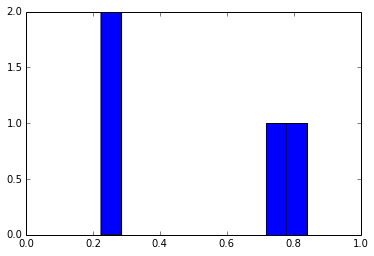

In [152]:
plt.hist(tendCurr)
plt.xlim(0,1)

# Relationship between characterization methods and consensus over the characterization method  (reporting style)

In [196]:
usageOfMaterialrep = np.array([])
protocolemployed = np.array([])
weightedAvgProtocol = np.array([])
usageOfMaterial = np.array([])
for m in model.exprCharc.keys():
    if np.where(model.exprCharc[m] > 1)[0].any():
        counter = 0#to count the number of times protocols were used
        distProtocols = len(model.exprCharc[m][np.where(model.exprCharc[m] > 1)[0]])
        #print(distProtocols)
        for i in np.arange(len(model.exprCharc[m])):
            if model.exprCharc[m][i] > 1:
                protocolemployed = np.append(protocolemployed, np.repeat(i, model.exprCharc[m][i] - 1 ))
                counter = counter + model.exprCharc[m][i] - 1
        usageOfMaterialrep = np.append(usageOfMaterialrep, np.repeat(counter, counter))
        weightedAvgProtocol = np.append(weightedAvgProtocol, counter / distProtocols)
        usageOfMaterial = np.append(usageOfMaterial, counter)

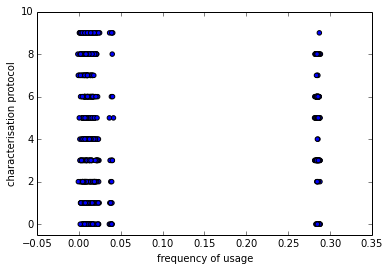

In [209]:
fig, ax = plt.subplots()
plt.scatter((usageOfMaterialrep + np.random.randn(len(usageOfMaterialrep)))/sum(usageOfMaterial), protocolemployed)
plt.ylim(-0.5, 10)
plt.ylabel("characterisation protocol")
plt.xlabel("frequency of usage")
plt.show()
fig.savefig('protocolsFreuqnecyUsage.pdf')# save the figure to file
plt.close(fig)

#plt.xlim(0,1)
#plt.xlim(1, np.max(usageOfMaterialrep) + 5)

In [134]:
sum(usageOfMaterial)

741.0

In [135]:
sum(model.allComb[:, 2])

792.0

## In order to capture the tendency to use similar protocols (spread of usage of protocols) the following plot captures the relationship between the relative usage of the main material and the spread in the protocol styles

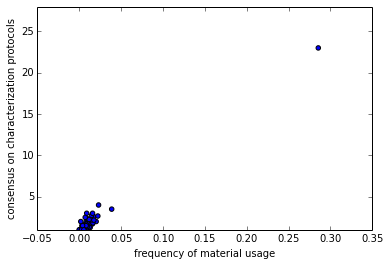

In [206]:
fig, ax = plt.subplots()
plt.scatter((usageOfMaterial + np.random.randn(len(usageOfMaterial))/2)/np.sum(usageOfMaterial), weightedAvgProtocol)
plt.ylim(1, max(weightedAvgProtocol) + 5)
plt.ylabel("")
plt.xlabel("frequency of material usage")
plt.ylabel("consensus on characterization protocols")
plt.show("consensus on characterization protocols")
fig.savefig('charactFreuqnecyUsage.pdf')# save the figure to file
plt.close(fig)

## Is there a correltation between the spread in the protocols and usage of materials? Is it stable over time?

In [185]:
thresholdList = np.linspace(start = 0.2,stop = 1,num = 10)
nRep = 20#how many repetitions for each innovation threshold value?
corrList = np.array([])
thresholtListRep = np.array([])
for t in thresholdList:
    for r in np.arange(nRep):
        model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, t, 3, 10)
        model.condUpdate = False
        model.allowMixing = False
        model.runModel(26)
        weightedAvgProtocol = np.array([])
        usageOfMaterial = np.array([])
        for m in model.exprCharc.keys():
            if np.where(model.exprCharc[m] > 1)[0].any():
                counter = 0#to count the number of times protocols were used
                distProtocols = len(model.exprCharc[m][np.where(model.exprCharc[m] > 1)[0]])
                #print(distProtocols)
                for i in np.arange(len(model.exprCharc[m])):
                    if model.exprCharc[m][i] > 1:
                        counter = counter + model.exprCharc[m][i] - 1
                weightedAvgProtocol = np.append(weightedAvgProtocol, counter / distProtocols)
                #print(weightedAvgProtocol)
                usageOfMaterial = np.append(usageOfMaterial, counter)
        corrList = np.append(corrList, np.corrcoef(usageOfMaterial, weightedAvgProtocol)[0,1])
        thresholtListRep = np.append(thresholtListRep, t)

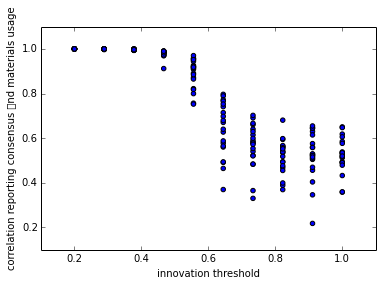

In [214]:
fig, ax = plt.subplots()
plt.scatter(thresholtListRep, corrList)
plt.ylabel("correlation reporting consensus \and materials usage")
plt.xlabel("innovation threshold")
plt.show()
fig.savefig('charactFreuqnecyPred.pdf')# save the figure to file
plt.close(fig)

### Conclusions from this section:
For low innovation tendency in terms of materials types employed, we observe there is a high correlation between the tendency to stick to similar or few reporting/characterization styles and materials. On the other hand, for high innovation tendency, the correlation between the usage of materials and the consensus over the reporting style is lower. This is due to the limited number of repetition per combination and therefore there are not enough opportunities to reach a consensus regarding the reporting style if the mechanism is repetition only. Therefore, if innovation is encourged via the investigation of more diverse materials, coherence of the experiments is not guranteed. In order to gurantee this external reinforcement is needed in the form of protocol templates for example.
Further aspects to investigate:
* Provided that repetition is the main mechanism for characterization styles, what is the threshold number above which the experiments will still reach consensus regarding the experimental characterization and 

# The Diversity index  over time:

(0.0, 1)

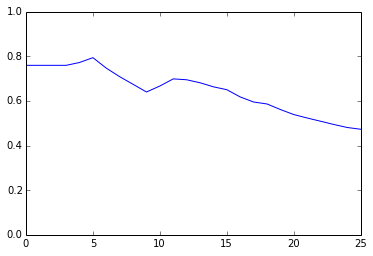

In [32]:
plt.plot(model.diversityIndex)
plt.ylim(0.,1)

(array([  1.33294619e+00,   9.18828236e-02,   3.48432056e-03,
          0.00000000e+00,   0.00000000e+00,   1.29048910e-04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.29048910e-04]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

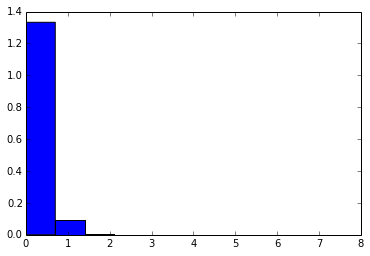

In [186]:
plt.hist(model.allComb[:,2],normed=True,cumulative=False)
#plt.xlim(1,30)

### Create the collaboration network from the agents attribute and add as a seperate attribute the number of unique combinations each agent was studied as a node attribute

In [462]:
collNetwork = np.chararray((1,1))
with open('sim_colnetwork.csv', 'w') as file:
    for key in model.agents_attribute.keys():
        #print(key)
        for colgroup in model.agents_attribute[key]["collaborators"]:
            for agent in colgroup:
            #print(["Agent" + str(key),"Agent" + str(col)])
                file.write("Agent" + str(key) + ";" + "Agent" + str(agent)+"\n")
#f.close()

In [232]:
model.experimentalNetwork()
model.exper_network.assortativity_degree()
model.exper_network.diameter()

4

In [217]:
model2.experimentalNetwork()

In [219]:
model2.exper_network.assortativity_degree()

-0.286183510993513

In [218]:
model2.exper_network.write_svg("graph.svg", layout=model2.exper_network.layout_kamada_kawai())

### Inspect the resulting collaboration network

### Inspect the parameters space

### Inspect the simulated experimental network

In [553]:
np.savetxt("empirical_network.csv",model.allComb,delimiter= ",")

I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group
I adjusted number of initial agents to the size of the collaboration group


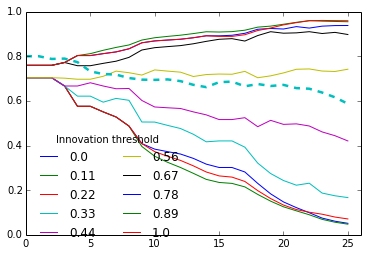

In [463]:
thresholdList = np.linspace(start = 0,stop = 1,num = 10)
nRuns = 26
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xValue = np.arange(nRuns)
for threshold in thresholdList:
    model = materialChoice(nAgents, pmTypes, domTypes, collSize,lifeExpect, newAgents, threshold)
    #model = materialChoice(nAgents,pmTypes,domTypes,collSize,threshold)
    model.InnovNoise = 0.0
    model.condUpdate = False#update agents tendency regardless of success in previous timestep
    model.allowMixing = False#don't allow mixing of the collaboration groups with newcomers
    model.runModel(nRuns)
    plt.plot(xValue,model.diversityIndex,label = str(np.round(threshold,decimals = 2)))
plt.plot(xValue,diversityEmpirical,'--',linewidth =2.5)
plt.legend(loc="upper left", bbox_to_anchor=[0, 0.5],
           ncol=2, shadow=False, title="Innovation threshold", fancybox=True,frameon=False)
plt.xlim(0,26)
pp = PdfPages('simDiveristyIndex' + '.pdf')
pp.savefig(fig)
pp.close()

### Is there an attractor in the system?

To inspect this by plotting the range of opinion differences and the outcome diversity

In [ ]:
thresholdList = np.linspace(start = 0,stop = 1,num = 1000)
nRuns = 26
diversityList = []
opinionRangeList = []
nOpinions = []
for threshold in thresholdList:
    for j in np.arange(10):#for each diversity 10 runs are made to capture the stochasticity in the model
        model = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        model.runModel(nRuns)
        tendCurr = []
        for key in model.agents_attribute.keys():
            tendCurr.append(model.agents_attribute[key]["current tendency"])
        opinionRangeList.append(max(tendCurr)-min(tendCurr))
        nOpinions.append(len(np.unique(tendCurr)))
        diversityList.append(model.diversityIndex[nRuns-1])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.scatter(opinionRangeList,diversityList)

# Questions to answer with the model:

### How stable are the number of researchers, collaboration group distribution and number of experiments done over different values of diversity?

#### The number of researchers and the number of experiments: it is evident that the number of researchers is always the same and the number of experiments varies (as it is affected by the number of active collaboration groups) however there is no significant effect for the innovation value. From this we can conclude that there is no significant effect of the innovation threshold on the collaboration group formation.

In [187]:
thresholdList = np.linspace(start = 0,stop = 1,num = 10)
nRuns = 26
nSimulations = np.arange(20)
nExperiments = np.zeros((len(nSimulations),len(thresholdList)))
nResearchers = np.zeros((len(nSimulations),len(thresholdList)))
for threshold in np.arange(len(thresholdList)):
    for s in np.arange(len(nSimulations)):
        model.condUpdate = False
        model.allowMixing = False
        #model = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,thresholdList[threshold])
        model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents,thresholdList[threshold], 3, 10)
        model.runModel(nRuns)
        nExperiments[s][threshold] = sum(model.allComb[:,2])

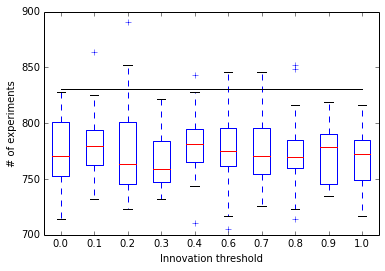

In [190]:
fig, ax = plt.subplots()
plt.boxplot(nExperiments)
ax.set_xticklabels(np.round(thresholdList,decimals = 1))
plt.plot((1,10), (831, 831), 'k-')#oribginally the x lables are from 1 to 10 since these are the indices of the nested array
plt.ylabel("# of experiments")
plt.xlabel("Innovation threshold")
plt.show()
fig.savefig('nSimulatedExperiemnts.pdf')   # save the figure to file
plt.close(fig)

#### What are the parameters that correspond to the empirical data? In what respect does the simulation look like the empirical data?
* Do the agents that have more collaborators also studied more combinations? can it be explained by the fact that they are longer time in the field? Is it also the case in the empirical network?
* Do the researchers that stay longer have more 

In [589]:
nAgents = len(model.agents_attribute)

# number of the collaborators correlates with the 
nSim = 10
agents = list(model.agents_attribute.keys())
nComb = np.array([])# aplace holder to see whether the
# number of the collaborators correlates with the
nExpr = np.array([])
diversityPerAgent = np.array([])
agentAge = np.array([])
nCollaborators = np.array([])# aplace holder to see whether the
for sim in np.arange(nSim):
    model = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,0.3)
    model.condUpdate = False
    model.allowMixing = True
    model.runModel(26)
    agents = list(model.agents_attribute.keys())
    for n in np.arange(len(agents)):
        col = [val for group in model.agents_attribute[str(agents[n])]["collaborators"] for val in group]
        nCollaborators = np.append(nCollaborators, len(np.unique(col)))
        comb = [val for group in model.agents_attribute[str(agents[n])]["comb studied"] for val in group]
        nComb = np.append(nComb, len(np.unique(comb)))
        nExpr = np.append(nExpr, len(comb))
        if len(comb) > 0:
            diversityPerAgent = np.append(diversityPerAgent, len(np.unique(comb))/len(comb))
        else:
            diversityPerAgent = np.append(diversityPerAgent, np.nan)
        agentAge = np.append(agentAge, model.agents_attribute[str(agents[n])]["age"])
    

In general there is a positive correlation between the number of collaborators and the number of unique combinations a given agent studies:

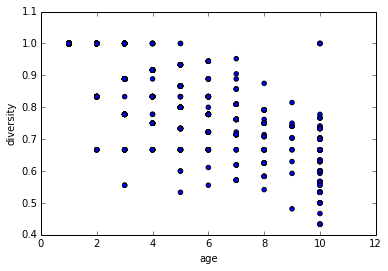

In [590]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(agentAge, diversityPerAgent)
plt.xlabel("age")
plt.ylabel("diversity")
#plt.ylim(0.2,1.01)

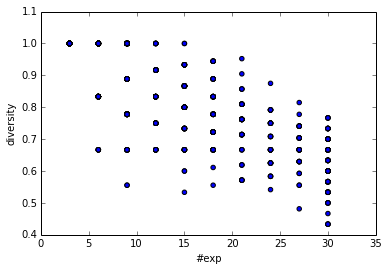

In [591]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(nExpr, diversityPerAgent)
plt.xlabel("#exp")
plt.ylabel("diversity")
#plt.ylim(0.2,1.01)

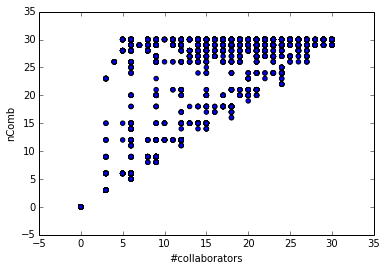

In [543]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(nCollaborators, nComb)
plt.xlabel("#collaborators")
plt.ylabel("nComb")
#plt.ylim(0.2,1.01)

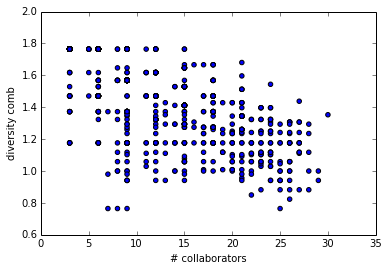

In [592]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(nCollaborators,diversityPerAgent/(max(diversityPerAgent)-min(diversityPerAgent)))
plt.xlabel("# collaborators")
plt.ylabel("diversity comb")
#plt.ylim(0.2,1.01)

In [593]:
max(diversityPerAgent)-min(diversityPerAgent)

0.56666666666666665

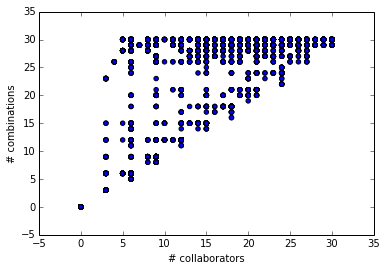

In [545]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(nCollaborators, nComb)
plt.ylabel("# combinations")
plt.xlabel("# collaborators")
#plt.scatter(nCollaborators,nComb,color = "red")

Can it be due to more time spent in the system?  more time to carry out experiemnts? Inconclusive

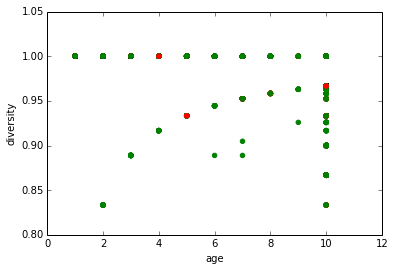

In [546]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
color = []
for n in np.arange(len(nCollaborators)):
    if nCollaborators[n] > 5:
        color.append("red")
    else:
        color.append("green")
plt.scatter(agentAge, diversityPerAgent,color = color)
plt.ylabel("diversity")
plt.xlabel("age")
#add here a legend

In [504]:
np.corrcoef(agentAge, diversityPerAgent)

array([[  1.,  nan],
       [ nan,  nan]])

In [505]:
diversityPerAgent

array([ 1.        ,  0.76666667,  1.        , ...,  1.        ,
        1.        ,  1.        ])

It seems that the age of a researcher does not determine the number of collaborators one has

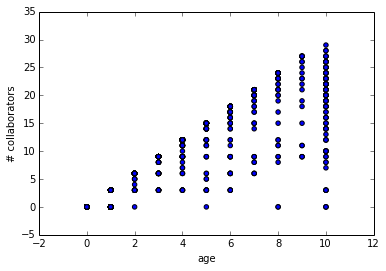

In [558]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#plt.scatter(nCollaborators,agentAge)
plt.scatter(agentAge, nCollaborators)
plt.ylabel("# collaborators")
plt.xlabel("age")

In [502]:
np.corrcoef(agentAge, nCollaborators)

array([[ 1.        ,  0.69644694],
       [ 0.69644694,  1.        ]])

#### Trends in diversity index:

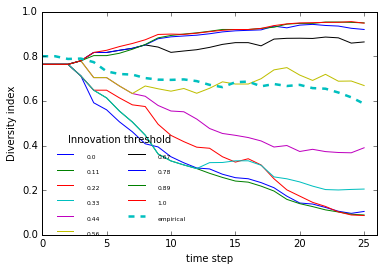

In [1189]:
thresholdList = np.linspace(start = 0,stop = 1,num = 10)
nRuns = 26
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xValue = np.arange(nRuns)
for threshold in thresholdList:
    model = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
    #model = materialChoice(nAgents,pmTypes,domTypes,collSize,threshold)
    model.runModel(nRuns)
    plt.plot(xValue,model.diversityIndex,label = str(np.round(threshold,decimals = 2)))
plt.plot(xValue,diversityEmpirical,'--',linewidth =2.5,label = "empirical")
plt.legend(loc="upper left", bbox_to_anchor=[0, 0.5],
           ncol=2, shadow=False, title="Innovation threshold", fancybox=True,frameon=False)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.xlim(0,26)
plt.ylabel("Diversity index")
plt.xlabel("time step")
pp = PdfPages('simDiveristyIndex' + '.pdf')
pp.savefig(fig)
pp.close()

#### In what regime of innovation threshold are the results stable?

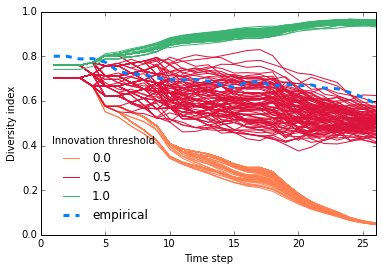

In [227]:
nSiumlations = 100
nRuns = 26
xValue = np.arange(nRuns) + 1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = ["#FF7F50","#DC143C","#3CB371"]
c = 0
for threshold in np.array([0,0.5,1]):
    label = True
    for n in np.arange(nSiumlations):
        #set the model:
        model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10)
        model.allowMixing = False
        model.conUpdate = False
        model.runModel(nRuns)
        if label:#label only one instance of each threshold value
            plt.plot(xValue,model.diversityIndex,color = colors[c], label = str(threshold))
        else:
            plt.plot(xValue,model.diversityIndex,color = colors[c])
        label = False
    c = c+1
plt.plot(xValue,diversityEmpirical,'--',linewidth =3,color = "#0080FF",label = "empirical")
plt.legend(loc='lower left',frameon=False,title = "Innovation threshold",bbox_to_anchor=[0, 0.01])    
plt.ylim(0,1)
plt.xlim(0,26)
plt.ylabel("Diversity index")
plt.xlabel("Time step")
pp = PdfPages('stabilityRegions' + '.pdf')
pp.savefig(fig)
pp.close()

#### How will longer "life expectancy" affect the diversity and "opinion" of researchers?

#### What is the stochastic effect on the outcome?

#### When does a phase transfer between lock-in effect and continous innovation occur?

#### What is the effect of collaboration group size on the outcomes?

#### What can be the reasons for local fluctuations?

#### What parameters/processes can be neglected without affecting the simulation output?

#### With what respect does the simulated system differs from the empirical data? Why?

#### The properties of the experimental network
* degree assortativity
* diameter
* shortest path
* number of nodes
* number of links
* Diversity index at the end of the simulation

In [323]:
nSIm = 1000
#thresholdList = np.linspace(start = 0,stop = 1,num = 10, )
thresholdList = np.arange(11)/10
nRuns = 26

In [324]:
expNetworkStat = np.zeros((1, 6))# a place holder for the results,
#the first column is for the innovation threshold

In [325]:
nSIm = 1000
#thresholdList = np.linspace(start = 0,stop = 1,num = 10, )
thresholdList = np.arange(11)/10
nRuns = 26
expNetworkStat = np.zeros((1, 6))# a place holder for the results,
#the first column is for the innovation threshold
for threshold in thresholdList:
    label = True
    for n in np.arange(nSIm):
        #set the model:
        model = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10)
        model.allowMixing = True
        model.conUpdate = False
        model.autoregress = True
        model.runModel(nRuns)
        model.experimentalNetwork()
        results = np.array([threshold,\
                            model.exper_network.diameter(),\
                            model.exper_network.vcount(),\
                            model.exper_network.ecount(),\
                            model.exper_network.assortativity_degree(),\
                            model.diversityIndex[-1]])
        expNetworkStat = np.vstack((expNetworkStat, results))
expNetworkStat =expNetworkStat[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("exp_network_simul_yesAutoregg_mix.csv", expNetworkStat, delimiter = ",")
#model.exper_network.vcount()

In [326]:
expNetworkStat =expNetworkStat[1:, :]#eliminating the first line, which was only a place holder...
#export to csv:
np.savetxt("exp_network_simul_yesAutoregg_mix.csv", expNetworkStat, delimiter = ",")
#model.exper_network.vcount()

#### What are the implication of the simulated results on the understanding of the experimental design?

The fact that the simulation managed to capture the qualitative properties of the collaboration network implies that similar processes can be found in real life, in particular it is plausible that researchers enter the field in already formed collaboration groups and not pair-up with researchers that already present in the system. When the agents do pair up with agents already in the system we observe a much larger connected component that doesn't resemble the empirical collaboration network. This manner of collaboration also affect the exchange of ideas as is reflected by the distribution of opinions: upon mixing the ideas at the end of the simulations are more centered compared to the situation when new researchers enter the field already paired in collaboration groups. The latter, as stated, resembles more the empirical case. The effect is more profound as we propegate the simulation to the future (however, in such case we are highly uncertain about the number of researchers that eneter the field in each year, since the observed exponential increase in those is unlikely to remain in the future).

# The effect of mixing

##### Distribution of opinions at the end of the simulation without mixing between newcomers and existing researchers:

In [1144]:
threshold = 0.7
nSIm = 100

In [1145]:
tendCurrNoMix = []
for n in np.arange(nSIm):
    modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
    modelNotMix.allowMixing = False
    modelNotMix.conUpdate = False
    modelNotMix.runModel(26)
    for key in modelNotMix.agents_attribute.keys():
        val = modelNotMix.agents_attribute[key]["current tendency"]
        if type(modelNotMix.agents_attribute[key]["current tendency"]) == np.ndarray:
            val = np.double(val)
        tendCurrNoMix.append(val)

In [1146]:
tendCurrYesMix = []
for n in np.arange(nSIm): 
    modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
    modelYesMix.allowMixing = True
    modelYesMix.conUpdate = False
    modelYesMix.runModel(26)
    for key in modelYesMix.agents_attribute.keys():
        val = modelYesMix.agents_attribute[key]["current tendency"]
        if type(modelYesMix.agents_attribute[key]["current tendency"]) == np.ndarray:
            val = np.double(val)
        tendCurrYesMix.append(val)
        fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(tendCurrNoMix,label = "No mixing",bins = 20,color = "#B22222",normed=True,stacked = True)
plt.hist(tendCurrYesMix, label = "With mixing",bins = 20,color = "#90EE90",normed=True,stacked = True)
plt.legend(loc='upper right',frameon=False,title = "Innovation tendency = " + str(threshold))
plt.xlabel("Individual innovation")
plt.ylabel("Normalized frequency")
pp = PdfPages('tendencyDist' + '.pdf')
pp.savefig(fig)
pp.close()

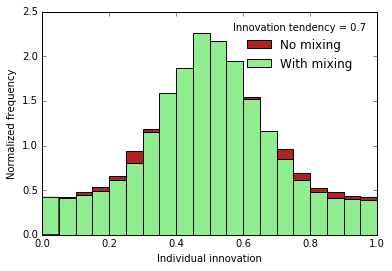

In [1147]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(tendCurrNoMix,label = "No mixing",bins = 20,color = "#B22222",normed=True,stacked = True)
plt.hist(tendCurrYesMix, label = "With mixing",bins = 20,color = "#90EE90",normed=True,stacked = True)
plt.legend(loc='upper right',frameon=False,title = "Innovation tendency = " + str(threshold))
plt.xlabel("Individual innovation")
plt.ylabel("Normalized frequency")
pp = PdfPages('tendencyDist' + '.pdf')
pp.savefig(fig)
pp.close()

Moreover the presence of mixing enhances the tendency in the system. If the overall tendency is for repetition (low innovation tendency) then mixed collaboration groups enahnces the reduction in the materials diversity. However, when innovation tendency is high mixing of collaboration groups increases the innovation comapred to the situation were researchers do not mix their collaboration groups. is in diversity of materials in the experiments in the long run. Therefore mixing of researchers bring them closer together enhancing the "main stream" thinking. This effect is especially profound as the repetition tenency increases (i.e. innovation decreases). 

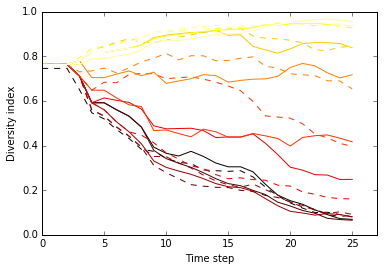

In [1190]:
thresholdList = np.linspace(start = 0,stop = 1,num = 10)
nRuns = 26
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xValue = np.arange(nRuns)
colorIndex = np.arange(len(thresholdList))
for threshold in thresholdList:
    c = cm.hot(np.int(10*threshold)/9.,1)
    modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
    modelNotMix.allowMixing = False
    modelNotMix.runModel(nRuns)
    plt.plot(xValue,modelNotMix.diversityIndex,label = str(np.round(threshold,decimals = 2)),color = c)
    modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
    modelYesMix.allowMixing = True
    modelYesMix.runModel(nRuns)
    plt.plot(xValue,modelYesMix.diversityIndex,'--',color = c)#,label = str(threshold))
#plt.legend(loc="lower left", bbox_to_anchor=[0, -0.1],
       #    ncol=2, shadow=False, title="Innovation tendency", fancybox=True,frameon=True)
#leg = plt.gca().get_legend()#to change the font size in the legend
#ltext  = leg.get_texts()
#plt.setp(ltext, fontsize=6)
plt.xlim(0,nRuns+1)
plt.ylabel("Diversity index")
plt.xlabel("Time step")
pp = PdfPages('mixEffectOnDiversity' + '.pdf')
pp.savefig(fig)
pp.close()

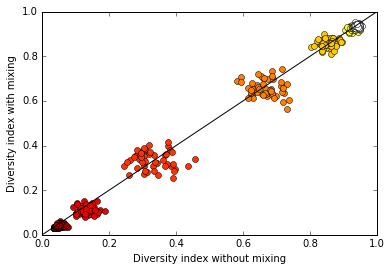

In [1079]:
thresholdList = np.linspace(start = 0,stop = 1,num = 10)
nRuns = 26
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xValue = np.arange(nRuns)+1
colorIndex = np.arange(len(thresholdList))
nSim = 50
for threshold in thresholdList:
    c = cm.hot(np.int(10*threshold)/9.,1)
    for n in np.arange(nSim):
        modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelNotMix.condUpdate = False
        modelNotMix.allowMixing = False
        modelNotMix.runModel(nRuns)
        modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelYesMix.condUpdate = False
        modelYesMix.allowMixing = True
        modelYesMix.runModel(nRuns)
        plt.plot(modelNotMix.diversityIndex[-1],modelYesMix.diversityIndex[-1],"o",color = c)#,label = str(threshold))
plt.plot([0, 1], [0, 1], 'k-', lw=1)#the 1 to 1 line
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("Diversity index with mixing")
plt.xlabel("Diversity index without mixing")
#pp = PdfPages('mixEffectOnDiversityRatio' + '.pdf')
#pp.savefig(fig)
#pp.close()

Clearly diversity improves upon mixing if the overall tendency in the system is to innovate, however, diversity gets worse upon mixing as the innovation tendency becomes lower. Therefore mixing served as a catalizator for the common state of mind.

### The effect of mixing on the trend in the diversity index:

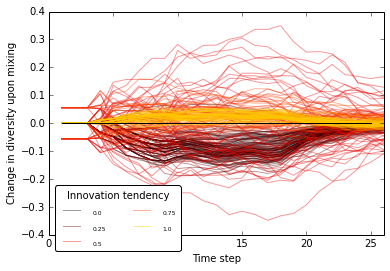

In [221]:
thresholdList = np.linspace(start = 0,stop = 1,num = 5)
nRuns = 26
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xValue = np.arange(nRuns)+1
colorIndex = np.arange(len(thresholdList))
nSim = 50
for threshold in thresholdList:
    c = cm.hot(np.int(10*threshold)/15.,alpha = 0.4)
    label = True
    for n in np.arange(nSim):
        #modelNotMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelNotMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10)
        modelNotMix.condUpdate = False
        modelNotMix.allowMixing = False
        modelNotMix.runModel(nRuns)
        #modelYesMix = materialChoice(nAgents,pmTypes,domTypes,collSize,lifeExpect,newAgents,threshold)
        modelYesMix = materialChoice(nAgents, pmTypes, domTypes, collSize, lifeExpect, newAgents, threshold, 3, 10)
        modelYesMix.condUpdate = False
        modelYesMix.allowMixing = True
        modelYesMix.runModel(nRuns)
        diffVal = np.array(modelYesMix.diversityIndex)-np.array(modelNotMix.diversityIndex)
        if label:#label each color only once
            plt.plot(xValue,diffVal,color = c,label = str(np.round(threshold,decimals = 2)))#,label = str(threshold))
        else:
            plt.plot(xValue,diffVal,color = c)
        label = False

plt.legend(loc="lower left", bbox_to_anchor=[0, -0.1],
           ncol=2, shadow=False, title="Innovation threshold", fancybox=True,frameon=True)
leg = plt.gca().get_legend()#to change the font size in the legend
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=6)
plt.plot([1, 25], [0, 0], 'k-', lw=1)#the 1 to 1 line
plt.xlim(0,26)
#plt.ylim(0,1)
plt.ylabel("Change in diversity upon mixing")
plt.xlabel("Time step")
pp = PdfPages('mixEffectOnDiversitydiff' + '.pdf')
pp.savefig(fig)
pp.close()

### Old code:

In [ ]:
    def chooseMaterialWithPrefOppos(self):
        """This function chooses materials for innovative researchers, that is more likely to sample rows that have low weight"""
        rows = np.where(self.allComb[:,2] == 0)[0]
        print(rows)
        #print(self.allComb[rows,0])
        comChosen = np.random.choice(rows,size=1,replace = False)
        #print(self.allComb[comChosen,:])
        if np.random.binomial(n = 1,p = 0.5):#the probability to study either PM or DOM as the main material
            #choose one PM and test it with x number of DOM based on the empirical probability
            nDOM = 4#the avergae number of DOM types each PM is studied with, (later will be drawn from empirical probability)
            pm = self.allComb[comChosen,0]#the pm that was chosen
            relevRows = np.where(self.allComb[np.where(self.allComb[:,0] == pm)[0],2] == 0.)[0]#the row numbers where this PM appears
            expConditons = np.random.choice(relevRows,size = nDOM,replace = False)#find corresponding ROWS DOM in 
            #a combination with the same PM as 'pm'
        else:#the main material to be studied in DOM
            nPM = 4#the avergae number of PM types a given DOM is studied with (later will be drawn from empirical probability)
            dom = self.allComb[comChosen,1]#the DOM that was chosen
            relevRows = np.where(self.allComb[np.where(self.allComb[:,1] == dom)[0],2] == 0.)[0]
            expConditons = np.random.choice(relevRows,size = nPM,replace = False)#find corresponding ROWS DOM in
        #print(self.allComb[relevRows,:])
        return(expConditons)

#### How do the results conform to the hypothesis of a lock-in effect?

#### What recommendation can be made?